## INTRO   

### 주제
- 앱 이용자 별 향후 이용 건수 예측
- 이용자 별 향후 이용 건수를 예측하여 마케팅, 영업 등의 의사 결정 과정에 활용
  
### 모델 개발 요건
- 이용자 별 결제 이력을 바탕으로 한 향후 한 달간 이용 건수 예측
  
### Data 정의
- Input: Tabular 데이터(2020.01.01 ~ 2020.12-31)
- Output: Regression (향후 이용 건수 예측)  

### Task 정의
- Regression, 유저 별 한 달 후 이용 건수 예측
  
### Metric 정의
- MSE, MAE
  
### 데이터 수집
- 유저 가입 정보: id(USER_ID) , 가입일(JOIN_DATE) 
- 소비 행동 정보: 상품id(GOODS_TYPE), 점포 주소(STORE_ID), 결제일(DATE), 결제건수(COUNT) 
- 외부 정보: 서울시 지점별 교통량 데이터 기온, 강수량, 풍속 등 기상데이터  

## Data Load   
### Library

In [2]:
import pandas as pd 
import numpy as np 
import missingno as msno
from datetime import datetime, timezone, timedelta
import pytz
from tqdm.notebook import tqdm as tqdm

import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False  

# API 크롤링 라이브러리 
from urllib.parse import urlencode, quote_plus
from urllib.request import Request, urlopen
from xml.etree import ElementTree 
from urllib.error import HTTPError, URLError
import requests

from statsmodels.tsa.seasonal import seasonal_decompose 

#model 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error


pd.options.display.max_rows=1000

### Load

In [3]:
data = pd.read_csv('../project_modu/data_modu.csv')
data.drop(columns=['Unnamed: 0', 'Year'], inplace=True)
data.weekofday=data.weekofday.astype(int)

In [4]:
print(f'데이터 사이즈 : {data.shape}')

데이터 사이즈 : (879271, 11)


In [ ]:
# msno.matrix(data)  #missing values (X) 

In [ ]:
data.info()

In [5]:
data['DATE']=pd.to_datetime(data['DATE'])
data['JOIN_DATE']=pd.to_datetime(data['JOIN_DATE'])

# 결제날짜 : 연도, 월, 일 컬럼 생성 
# data['Year'] = data.DATE.dt.year
# data['Month'] = data.DATE.dt.month
# data['Day'] = data.DATE.dt.day

# 가입날짜 : 연도, 월, 일 컬럼  -> 필요할까? 
# data['JOIN_Year'] = data.JOIN_DATE.dt.year
# data['JOIN_Month'] = data.JOIN_DATE.dt.month
# data['JOIN_Day'] = data.JOIN_DATE.dt.day

# 결제 요일 
# KST = pytz.timezone('Asia/Seoul')
# for idx, (m, d) in enumerate(zip(data.Month, data.Day)):
#     mydate = datetime(2020, m,d)
#     mydate_kst = KST.localize(mydate)
#     data.at[idx, 'weekofday'] = mydate_kst.weekday()

In [6]:
test=data[data['DATE']>='2020-10-01']
train = data[data['DATE']<'2020-10-01']

In [7]:
display(train.head(3))
display(test.head(3))

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,Month,Day,weekofday
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,1,1,2
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,1,1,2
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,1,1,2


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,Month,Day,weekofday
623579,15521,2014-09-12,AA,182320,A,2020-10-01,1,JRR,10,1,3
623580,17651,2014-09-19,BB,82434,D,2020-10-01,1,J,10,1,3
623581,26388,2014-10-25,BB,182320,A,2020-10-01,1,JRR,10,1,3


### 날씨 - API 크롤링 

In [8]:
# 공유된 데이터 확인
# weather = pd.read_csv('../project_modu/서울시_기상데이터.csv', encoding='CP949')

# 일자별 날씨로 크롤링 하기로 함 
# ------------------------ 크롤링
# url = 'http://apis.data.go.kr/1360000/AsosDalyInfoService/getWthrDataList'

# params = '?'+ 'ServiceKey=' + service_key + '&' + \
#     urlencode({ quote_plus('ServiceKey') : '서비스키', 
#                 quote_plus('dataType') : 'XML',
#                 quote_plus('pageNo') : '1', 
#                 quote_plus('numOfRows') : '366', 
#                 quote_plus('dataCd') : 'ASOS',
#                 quote_plus('dateCd') : 'DAY', 
#                 quote_plus('startDt') : '20200101',  
#                 quote_plus('endDt') : '20210101', 
#                 quote_plus('stnIds') : '108' })

               
# df = pd.DataFrame()
    
    
# request = Request(url + params)
# request.get_method = lambda: 'GET'

# try:
#     response_body = urlopen(request).read()
# except HTTPError as e:
#     print(e)
# except URLError as e:
#     print('The server coult not be found')
# else:
#     print('성공')


# root= ElementTree.fromstring(response_body)

# for item in root.iter('item'):
#     item_dict = {}
# #     지점, 일시, 기온, 강수량, 풍속, 습도, 일조시간, 적설량, 지면온도, 지중온도
#     item_dict['일시'] = item.find('tm').text
#     item_dict['지점'] = item.find('stnId').text
#     item_dict['평균기온'] = item.find('avgTa').text
#     item_dict['일강수량'] = item.find('sumRn').text
#     item_dict['평균풍속'] = item.find('avgWs').text
#     item_dict['평균상대습도'] = item.find('minRhmHrmt').text
#     item_dict['가조시간'] = item.find('ssDur').text
#     item_dict['일적설량'] = item.find('ddMefs').text
#     item_dict['3시간 적설량'] = item.find('sumDpthFhsc').text
#     item_dict['지면온도'] = item.find('avgTs').text
#     item_dict['평균10cm 지중온도'] = item.find('avgCm10Te').text
#     item_dict['평균5cm 지중온도'] = item.find('avgCm5Te').text
#     item_dict['평균20cm 지중온도'] = item.find('avgCm20Te').text
    
#     df=df.append(item_dict, ignore_index=True)

# # df.to_csv(path_or_buf =r'weather_day.csv', encoding='euc-kr')

# print(df)

# # weather_day = pd.read_csv('./weather_day.csv', encoding='CP949')
# # weather_day=weather_day[['지점','일시', '평균기온', '일강수량', '평균풍속','평균상대습도','가조시간','일적설량','3시간 적설량', '평균5cm 지중온도', '평균10cm 지중온도']]


# # # ------------------------ csv 
# # weather_day.to_csv('../project_modu/weather_day.csv')

In [9]:
weather_day = pd.read_csv('../project_modu/weather_day.csv')
weather_day.drop(columns=['Unnamed: 0'], inplace=True)

In [10]:
weather_day.columns=['point', 'weather_date', 'avgTemp', 'rainfall_Day', 'avgWind',
       'avgHumid', 'du_sunshine', 'snow_day', 'snow_3h', 'avg5cm', 'avg10cm']
weather_day.head()

,point,weather_date,avgTemp,rainfall_Day,avgWind,avgHumid,du_sunshine,snow_day,snow_3h,avg5cm,avg10cm
0,108,2020-01-01,-2.2,0.1,0.6,2,9.6,0.0,0.0,-0.4,0.5
1,108,2020-01-02,1.0,NaN,1.2,1212,9.6,NaN,NaN,0.0,0.7
2,108,2020-01-03,-0.1,NaN,1.7,1430,9.7,NaN,NaN,0.3,1.0
3,108,2020-01-04,1.2,NaN,1.9,1457,9.7,NaN,NaN,0.4,1.1
4,108,2020-01-05,1.3,NaN,1.1,1518,9.7,NaN,NaN,0.2,1.0


### 미세먼지 경보 - API 크롤링 

In [ ]:
# # 미세먼지 날씨로 크롤링 하기로 함 
# # ------------------------ 크롤링

# url = 'http://apis.data.go.kr/B552584/UlfptcaAlarmInqireSvc/getUlfptcaAlarmInfo'

# params = '?'+ 'ServiceKey=' + service_key + '&' + \
#     urlencode({ quote_plus('ServiceKey') : '서비스키', 
#                 quote_plus('numOfRows') : '500', 
#                quote_plus('returnType') : 'xml',
#                quote_plus('year') : '2020' })


               
# df = pd.DataFrame()
    
       
# request = Request(url + params)
# request.get_method = lambda: 'GET'

# try:
#     response_body = urlopen(request).read()
# except HTTPError as e:
#     print(e)
# except URLError as e:
#     print('The server coult not be found')
# else:
#     print('성공')

# root= ElementTree.fromstring(response_body)

# for item in root.iter('item'):
#     item_dict = {}
#     item_dict['발령일'] = item.find('dataDate').text
#     item_dict['지역명'] = item.find('districtName').text
#     item_dict['권역명'] = item.find('moveName').text
#     item_dict['항목명'] = item.find('itemCode').text
#     item_dict['경보단계'] = item.find('issueGbn').text
#     item_dict['발령일'] = item.find('issueDate').text
#     item_dict['발령시간'] = item.find('issueTime').text
#     item_dict['발령농도'] = item.find('issueVal').text

    
#     df=df.append(item_dict, ignore_index=True)
# #     print(df)

# # df.to_csv(path_or_buf =r'dust.csv', encoding='euc-kr')

# print(df)

# # dust = pd.read_csv('dust.csv', encoding='CP949')
# dust =dust.sort_values('발령일')
# df.to_csv(path_or_buf =r'dust.csv', encoding='euc-kr')



# # ------------------------ csv 


In [11]:
dust = pd.read_csv('dust.csv', encoding='CP949')
# dust

In [12]:
dust_df=dust[(dust['지역명']=='경기')|(dust['지역명']=='서울')]

### 교통량 정보   
- 지점명 = 위치정보  .. 해당 위치에 얼마나 많은 교통량이 있었는가의 정보  
- 시간대별 유입과 유출 모두 있으므로 일자별 계산을 어떻게 해야할 것인지 정해야함.  
예를 들면 +유입-유출 이렇게 계산을 할 것인지.. 

In [13]:
traffic = pd.read_csv('../project_modu/교통량통합.csv', encoding='CP949')
traffic['DATE']=pd.to_datetime(traffic['DATE'])

In [ ]:
# traffic.columns = traffic.iloc[0]
# traffic=traffic.iloc[1:]

In [ ]:
# traffic.head(3)

### 도로명 주소 

In [ ]:
# road = pd.read_excel('../project_modu/도로명정보조회.xls')
# road.columns=road.iloc[0]
# road=road.iloc[1:]

### Data Merging 
  
on = Date,  원데이터셋 + 일자별 평균기온, 강수량, 적설량 ... + 일자별 교통량? 

In [ ]:
# weather_day.info()
# weather_day['일강수량'].fillna(0, inplace=True)
# weather_day['일적설량'].fillna(0, inplace=True)
# weather_day['3시간 적설량'].fillna(0, inplace=True)

In [14]:
weather_day['weather_date']=pd.to_datetime(weather_day['weather_date'])
# data_all=pd.merge(data, weather_day, left_on='DATE', right_on='weather_date')

**Basic Set + Dust**

In [ ]:
# dust_df['발령일'].unique()

In [15]:
dust_date=['2020-01-03', '2020-01-19', '2020-02-01', '2020-02-02',
       '2020-02-14', '2020-02-21', '2020-02-22', '2020-03-09',
       '2020-04-22', '2020-05-11', '2020-10-22', '2020-10-28',
       '2020-11-13', '2020-11-15', '2020-11-16', '2020-12-10',
       '2020-12-11', '2020-12-23']

# 미세먼지 경보가 발생한 날=1 아닌날=0
data['dust_yn']=data["DATE"].isin(dust_date).astype(int)

## Data Understanding 

In [16]:
data.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,Month,Day,weekofday,dust_yn
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,1,1,2,0
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,1,1,2,0
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,1,1,2,0
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,1,1,2,0
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,1,1,2,0


### 중복 ID가 있는가? 

In [17]:
print(f'기록된 유저ID 갯수 : {len(data["USER_ID"])}')
print(f'중복값을 제거한 고유 유저ID 갯수 :{data["USER_ID"].nunique()}')

기록된 유저ID 갯수 : 879271
중복값을 제거한 고유 유저ID 갯수 :165425


In [18]:
print(f'test 데이터 셋에만 있는 고유 ID : {len(set(test.USER_ID)-set(train.USER_ID))}')
print(f'train 데이터 셋에만 있는 고유 ID : {len(set(train.USER_ID)-set(test.USER_ID))}')
print(f'train & test 데이터 셋에 모두 있는 고유 ID : {len(set(train.USER_ID)&set(test.USER_ID))}')

test 데이터 셋에만 있는 고유 ID : 35165
train 데이터 셋에만 있는 고유 ID : 89465
train & test 데이터 셋에 모두 있는 고유 ID : 40795


### train, testset  - Distribution  
#### Y : COUNT (결제 횟수)  
  
- test set의 10~  20분포 << train set의 10~20분포 
- test set에는 40~61까지의 분포가 꽤 있는 반면 train set에는 없음.  

In [19]:
print(f'train set에서의 최소 결제수, 최대 결제수, 중위, 평균값  \n{train.COUNT.agg(["min", "max", "median", "mean"])}')
print('='*80)
print(f'test set에서의 최소 결제수, 최대 결제수, 중위, 평균값  \n{test.COUNT.agg(["min", "max", "median", "mean"])}')  

train set에서의 최소 결제수, 최대 결제수, 중위, 평균값  
min        1.000000
max       49.000000
median     1.000000
mean       1.027009
Name: COUNT, dtype: float64
test set에서의 최소 결제수, 최대 결제수, 중위, 평균값  
min        1.000000
max       61.000000
median     1.000000
mean       1.034127
Name: COUNT, dtype: float64


In [20]:
print(f'train set - count=1 : {(train["COUNT"]==1).sum()}  전체 비율 : {(train["COUNT"]==1).sum()/len(train.COUNT)}')
print(f'test set  - count=1 : {(test["COUNT"]==1).sum()}  전체 비율 : {(test["COUNT"]==1).sum()/len(test.COUNT)}')
print('='*80)
print(f'train set - count=2 : {(train["COUNT"]==2).sum()}  전체 비율 : {(train["COUNT"]==2).sum()/len(train.COUNT)}')
print(f'test set  - count=2 : {(test["COUNT"]==2).sum()}  전체 비율 : {(test["COUNT"]==2).sum()/len(test.COUNT)}')
print('='*80)
print(f'train set - count>=3 : {(train["COUNT"]>=3).sum()}  전체 비율 : {(train["COUNT"]>=3).sum()/len(train.COUNT)}')
print(f'test set  - count>=3 : {(test["COUNT"]>=3).sum()}   전체 비율 : {(test["COUNT"]>=3).sum()/len(test.COUNT)}')

#대강 비슷한 비율로 배치된 것 같음 

train set - count=1 : 612896  전체 비율 : 0.9828682492514982
test set  - count=1 : 250879  전체 비율 : 0.9811765718129625
train set - count=2 : 9360  전체 비율 : 0.015010127024803593
test set  - count=2 : 4159  전체 비율 : 0.01626566337624955
train set - count>=3 : 1323  전체 비율 : 0.0021216237236982003
test set  - count>=3 : 654   전체 비율 : 0.0025577648107879794


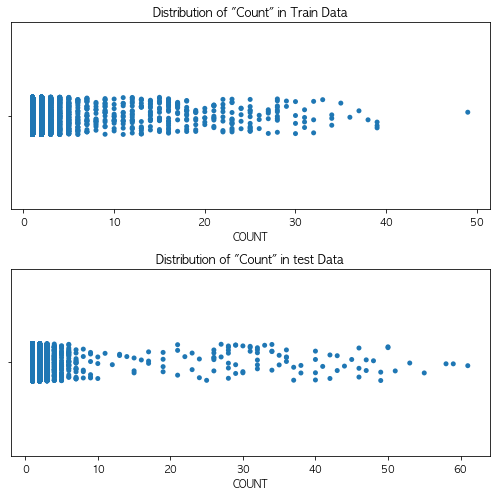

In [22]:
# sns.histplot(x='COUNT', data=data,hue='train/test', element="step");
f, axes=plt.subplots(2,1, figsize=(7,7))
sns.stripplot(x='COUNT', data=train, ax=axes[0])
axes[0].set_title('Distribution of "Count" in Train Data')

sns.stripplot(x='COUNT', data=test, ax=axes[1])
axes[1].set_title('Distribution of "Count" in test Data')
plt.tight_layout()
plt.show();

#test set의 10~20분포 << train set의 10~20분포 
#test set에는 30~61까지의 분포가 어느정도 있는 반면 train set에는 없음. 

In [21]:
print(f'train set - count=10~20 : {((train["COUNT"]>=10)& (train["COUNT"]<20)).sum()}')
print(f'test set  - count=10~20 : {((test["COUNT"]>=10)& (test["COUNT"]<20)).sum()}')
print('='*80)
print(f'train set - count>=30~40 : {((train["COUNT"]>=30)& (train["COUNT"]<40)).sum()}')
print(f'test set  - count>=30~40 : {((test["COUNT"]>=30)& (test["COUNT"]<40)).sum()}')
print('='*80)
print(f'train set - count>=40~50 : {((train["COUNT"]>=40)& (train["COUNT"]<50)).sum()}')
print(f'test set  - count>=40~50 : {((test["COUNT"]>=40)& (test["COUNT"]<50)).sum()}')
print('='*80)
print(f'train set - count>=50~70 : {((train["COUNT"]>=50)& (train["COUNT"]<70)).sum()}')
print(f'test set  - count>=50~70 : {((test["COUNT"]>=50)& (test["COUNT"]<70)).sum()}')

#40이상부터는 그냥 버려야하는 건가.. 

train set - count=10~20 : 153
test set  - count=10~20 : 19
train set - count>=30~40 : 22
test set  - count>=30~40 : 27
train set - count>=40~50 : 1
test set  - count>=40~50 : 19
train set - count>=50~70 : 0
test set  - count>=50~70 : 8


##### 월별

In [23]:
#월별 총 합계 
parking_1=data[data.Month==1]['COUNT'].groupby(data.Day).sum()
parking_2=data[data.Month==2]['COUNT'].groupby(data.Day).sum()
parking_3=data[data.Month==3]['COUNT'].groupby(data.Day).sum()
parking_4=data[data.Month==4]['COUNT'].groupby(data.Day).sum()
parking_5=data[data.Month==5]['COUNT'].groupby(data.Day).sum()
parking_6=data[data.Month==6]['COUNT'].groupby(data.Day).sum()
parking_7=data[data.Month==7]['COUNT'].groupby(data.Day).sum()
parking_8=data[data.Month==8]['COUNT'].groupby(data.Day).sum()
parking_9=data[data.Month==9]['COUNT'].groupby(data.Day).sum()

parking_10=data[data.Month==10]['COUNT'].groupby(data.Day).sum()
parking_11=data[data.Month==11]['COUNT'].groupby(data.Day).sum()
parking_12=data[data.Month==12]['COUNT'].groupby(data.Day).sum()

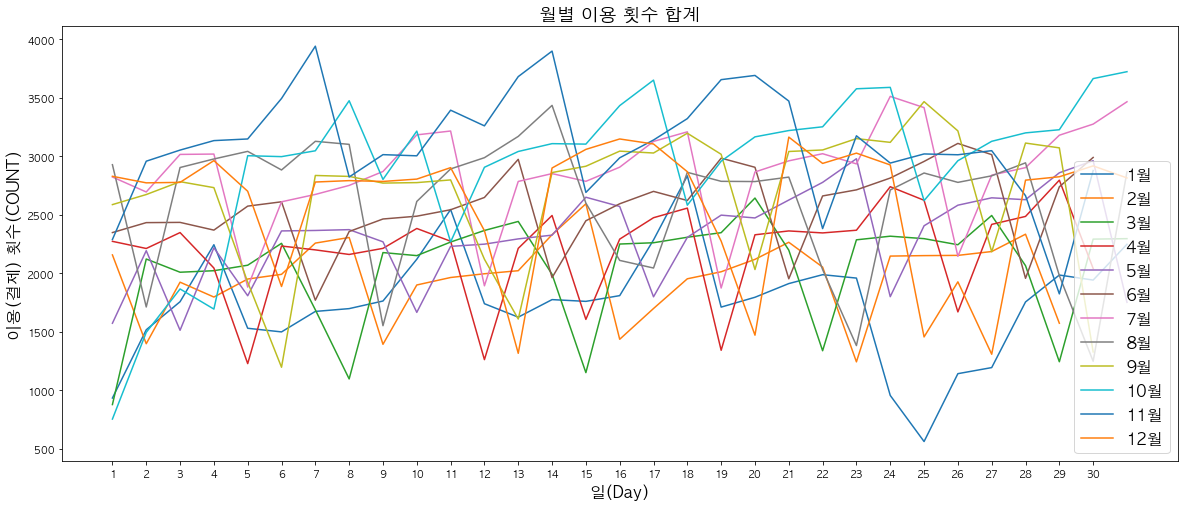

In [24]:
plt.figure(figsize=(20,8))
sns.lineplot(x=parking_1.index, y=parking_1.values)
sns.lineplot(x=parking_2.index, y=parking_2.values)
sns.lineplot(x=parking_3.index, y=parking_3.values)
sns.lineplot(x=parking_4.index, y=parking_4.values)
sns.lineplot(x=parking_5.index, y=parking_5.values)
sns.lineplot(x=parking_6.index, y=parking_6.values)
sns.lineplot(x=parking_7.index, y=parking_7.values)
sns.lineplot(x=parking_8.index, y=parking_8.values)
sns.lineplot(x=parking_9.index, y=parking_9.values)

sns.lineplot(x=parking_10.index, y=parking_10.values)
sns.lineplot(x=parking_11.index, y=parking_11.values)
sns.lineplot(x=parking_12.index, y=parking_12.values)

plt.xticks(np.arange(1, 31, step=1))
plt.legend(['1월', '2월', '3월', '4월','5월','6월','7월','8월','9월', '10월','11월','12월'], loc='best', fontsize=16)
plt.title('월별 이용 횟수 합계', fontsize=18)
plt.ylabel('이용(결제) 횟수(COUNT)', fontsize=16)
plt.xlabel('일(Day)', fontsize=16)
plt.show();

##### 분기별 

In [25]:
#월별로 보자니 복잡해서 분기별 혹은 계절별로 나눠보기로 함 

#분기 
data['quartile']=data['Month'].apply(lambda x : 1 if x<=3 else 2 if (x>3) & (x<=6) else 3 if (x>6) & (x<=9) else 4)

In [26]:
#분기별 
parking_1_4=data[data.quartile==1]['COUNT'].groupby(data.Day).sum()
parking_2_4=data[data.quartile==2]['COUNT'].groupby(data.Day).sum()
parking_3_4=data[data.quartile==3]['COUNT'].groupby(data.Day).sum()
parking_4_4=data[data.quartile==4]['COUNT'].groupby(data.Day).sum()

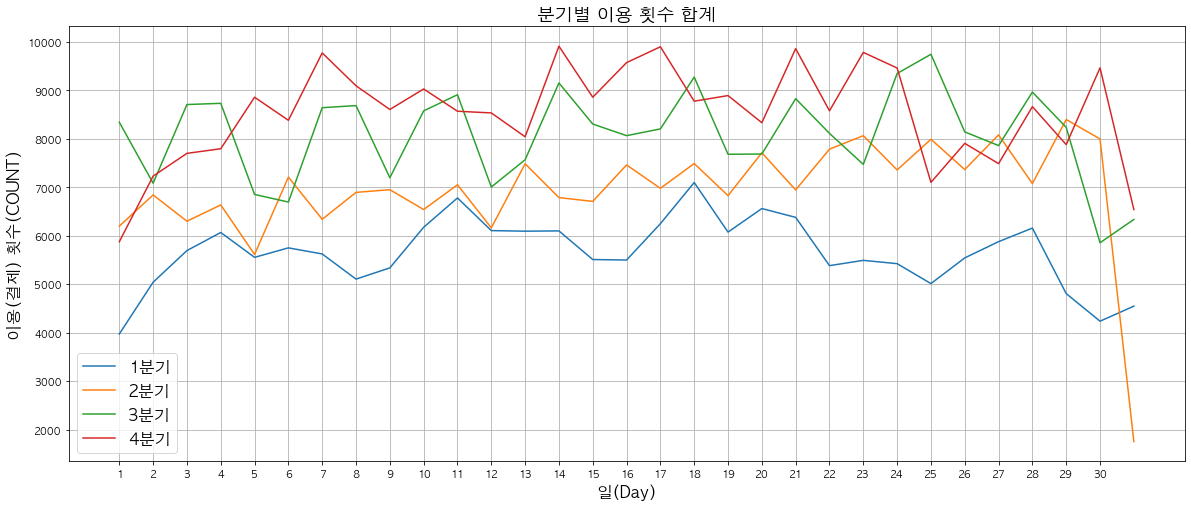

In [27]:
plt.figure(figsize=(20,8))
sns.lineplot(x=parking_1_4.index, y=parking_1_4.values)
sns.lineplot(x=parking_2_4.index, y=parking_2_4.values)
sns.lineplot(x=parking_3_4.index, y=parking_3_4.values)
sns.lineplot(x=parking_4_4.index, y=parking_4_4.values)

plt.grid()
plt.xticks(np.arange(1, 31, step=1))
plt.legend(['1분기', '2분기','3분기','4분기'], loc='best', fontsize=16)
plt.title('분기별 이용 횟수 합계', fontsize=18)
plt.ylabel('이용(결제) 횟수(COUNT)', fontsize=16)
plt.xlabel('일(Day)', fontsize=16)
plt.show();

# 1분기가 항상 낮고 3, 4분기가 엎치락 뒤치락함. 

In [28]:
# 딱히 seasonality, trend는 없음. cyclical 하기만 함. 
def plot_decompose(decomposerresult):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,8))
    decomposerresult.observed.plot(legend=False, ax=ax1)
    ax1.set_ylabel('Observed')
    decomposerresult.trend.plot(legend=False, ax=ax2)
    ax2.set_ylabel('Trend')
    decomposerresult.seasonal.plot(legend=False, ax=ax3)
    ax3.set_ylabel('Seasonal')
    decomposerresult.resid.plot(legend=False, ax=ax4)
    ax4.set_ylabel('Resid')

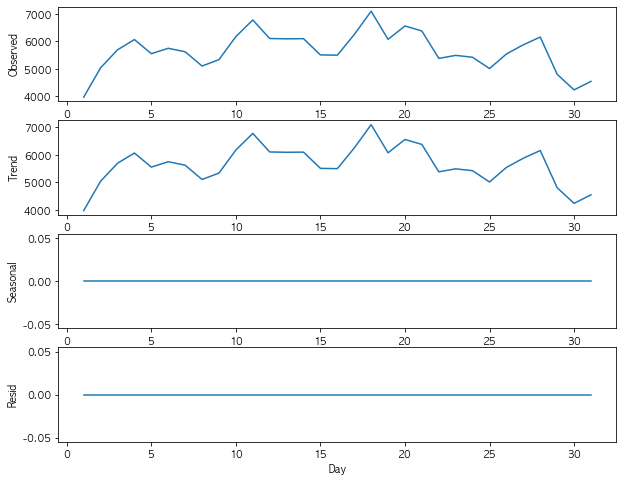

In [29]:
result = seasonal_decompose(parking_1_4, model = 'additive', period=1)
plot_decompose(result)

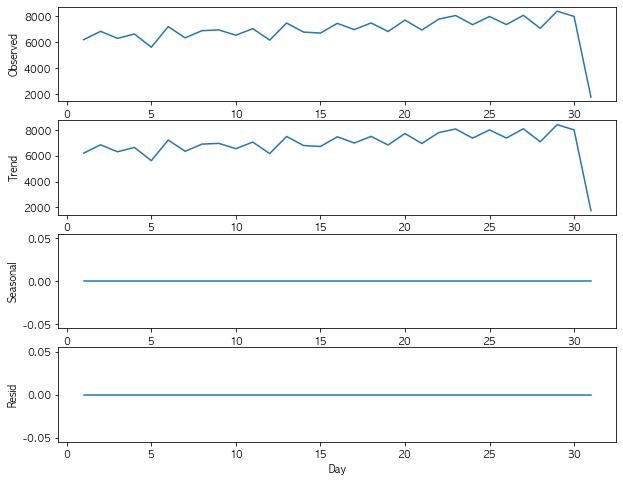

In [30]:
result = seasonal_decompose(parking_2_4, model = 'additive', period=1)
plot_decompose(result)

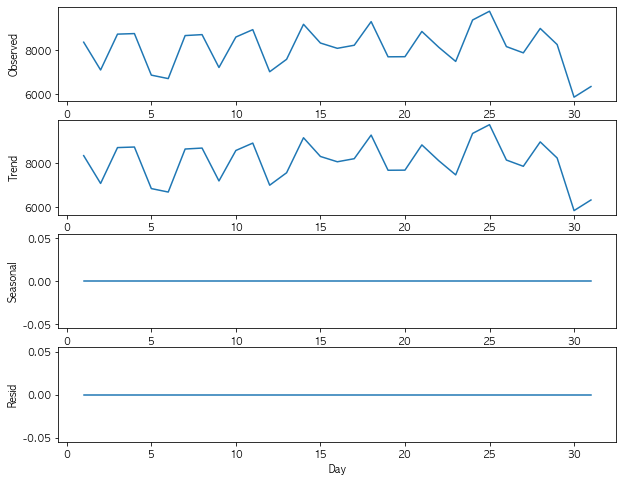

In [31]:
result = seasonal_decompose(parking_3_4, model = 'additive', period=1)
plot_decompose(result)

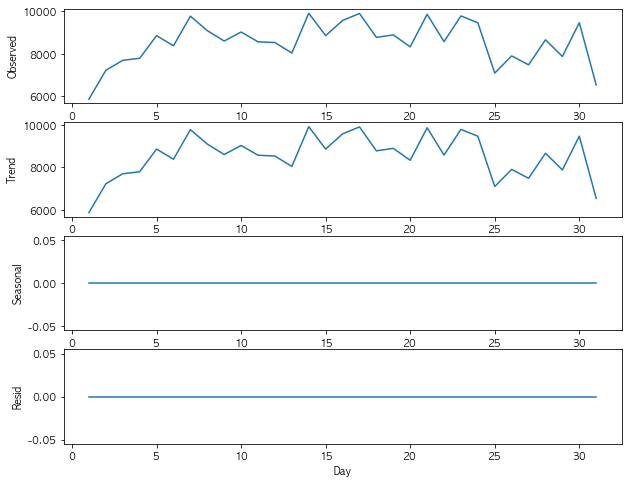

In [32]:
result = seasonal_decompose(parking_4_4, model = 'additive', period=1)
plot_decompose(result)

##### 요일별

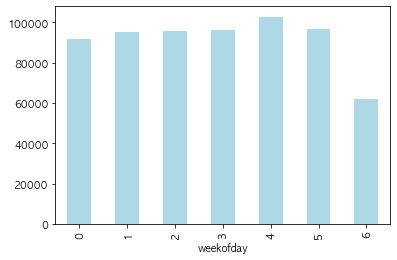

In [33]:
train.groupby('weekofday')['COUNT'].sum().plot(kind='bar', color='lightblue');
test.groupby('weekofday')['COUNT'].sum().plot(kind='bar', color='lightblue');
#0부터 순차적으로 월~일 
#대체로 비슷하고 일요일에 덜 함 

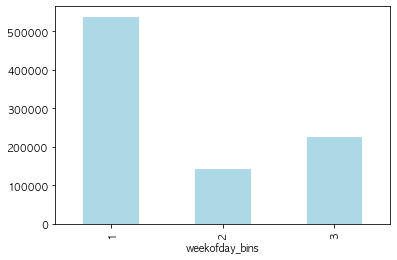

In [34]:
data['weekofday_bins']=data['weekofday'].apply(lambda x : 1 if x<=3 else 2 if x==4 else 3)
data.groupby('weekofday_bins')['COUNT'].sum().plot(kind='bar', color='lightblue');

# 1 : 월~목,  2: 금,  3: 토일 

##### GOODS_TYPE별 

In [ ]:
data.columns

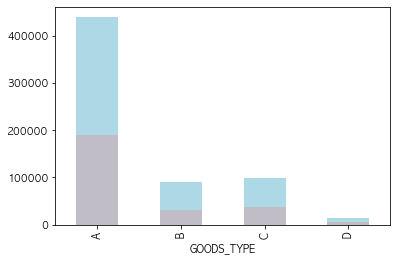

In [35]:
train.groupby('GOODS_TYPE')['COUNT'].sum().plot(kind='bar', color='lightblue');
test.groupby('GOODS_TYPE')['COUNT'].sum().plot(kind='bar', color='lightcoral', alpha=0.3);

##### D_TYPE별 

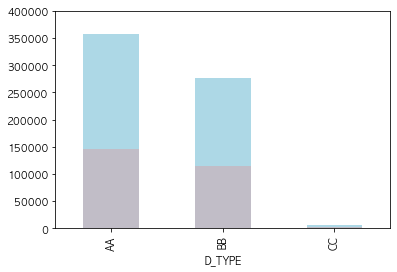

In [36]:
train.groupby('D_TYPE')['COUNT'].sum().plot(kind='bar', color='lightblue');
test.groupby('D_TYPE')['COUNT'].sum().plot(kind='bar', color='lightcoral', alpha=0.3, ylim=(0,400000));

In [37]:
data['JOIN_DAYS']=datetime(2020,12,31)-data['JOIN_DATE']
data['JOIN_DAYS']=data['JOIN_DAYS'].dt.days

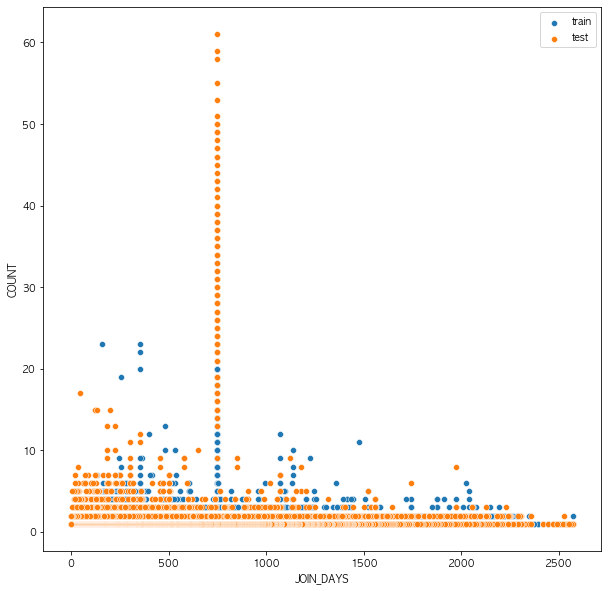

In [38]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='JOIN_DAYS', y='COUNT', data=data[(data.DATE <'2020-09-01')&(data.JOIN_DAYS<5000)])   #outliers 제거하고 
sns.scatterplot(x='JOIN_DAYS', y='COUNT', data=data[(data.DATE >='2020-09-01')&(data.JOIN_DAYS<5000)])
plt.legend(['train', 'test'])
plt.show();

# train으로 잡히지 않는 test.. 

## Correlation

### Given set + month, day, weekofday, Join days, quartile

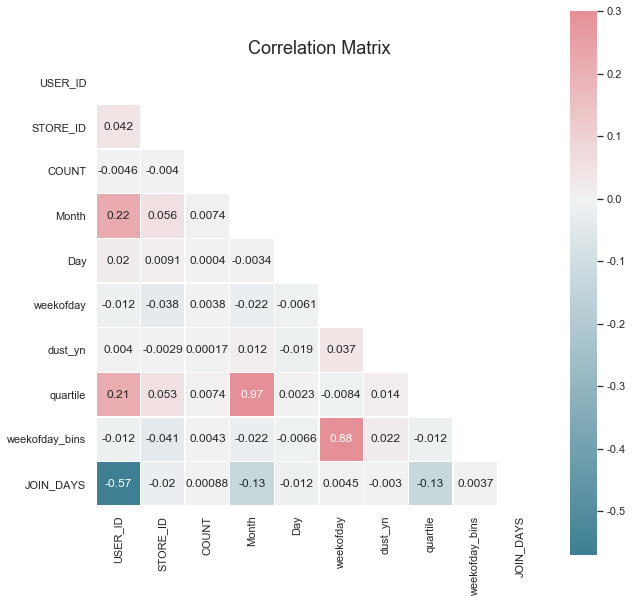

In [39]:
sns.set(style="white")
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True)
plt.show()

### + weather_day



In [47]:
data_weather=pd.merge(data, weather_day, left_on='DATE', right_on='weather_date')

In [48]:
data_weather.columns

Index(['USER_ID', 'JOIN_DATE', 'D_TYPE', 'STORE_ID', 'GOODS_TYPE', 'DATE',
       'COUNT', 'AD1', 'Month', 'Day', 'weekofday', 'dust_yn', 'quartile',
       'weekofday_bins', 'JOIN_DAYS', 'point', 'weather_date', 'avgTemp',
       'rainfall_Day', 'avgWind', 'avgHumid', 'du_sunshine', 'snow_day',
       'snow_3h', 'avg5cm', 'avg10cm'],
      dtype='object')

In [42]:
data_weather_corr=data_weather.corr()

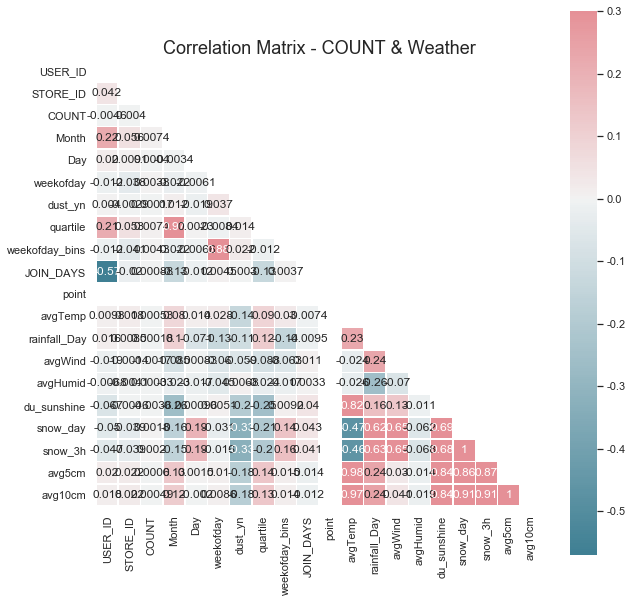

In [43]:
sns.set(style="white")
mask = np.triu(np.ones_like(data_weather_corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix - COUNT & Weather', fontsize=18)
sns.heatmap(data_weather_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True)
plt.show()


- train, test set의 COUNT간 특정 구간에 대한 분포차이가 있음. (train에는 없고 test에는 있는 구간) 이 구간에 속한 데이터들을 어떻게 해야할지 논의 필요  
- 거의 모든 COUNT가 1에 몰려있음 
- 시계열 데이터 특성을 사용한 분석이 필요한건지? 가능한건지? cyclical이 보이긴 한데 요것만 취해서 분석에 활용할 수 있는건지?  
- ID 컬럼 - 버리는 경우, 취하는 경우 모두 테스트 해 봐야할 듯?  
- D_TYPE, GOODS_TYPE, AD1 에 대한 정확한 정보 필요 
- 1차적으로는 COUNT 컬럼과 크게 상관있는 피처가 없어보임. Month제외하고. 그러니 외부 데이터를 활용해야 할 것 같은데 어떻게 활용할 건지? - 날씨 데이터 중 취할 피처, 교통량 정보는 어떻게 처리할건지   
  
    
-------------------  
  
**5/10 회의 결과 - 각자 모델 돌려보기**  

- 독립: AD1, dtype, goods type
- 1팀 김나영, 박근웅: 가입한지 얼마나 오래됐나
- 2팀 김태영, 이해강 : 요일, 공휴일
- 3팀 조아라, 정우주, 오병훈 : 일평균 기온

## Baseline Modeling  
### Score Boards

|Set|labeling|model|avg val MSE/MAE|test MSE/MAE|개별 Kfolds| 
|---|-----|---------|-----------|--------|------|
|Basic Set|label| RF|0.14/0.04|0.32/0.05|
|+AvgTemp|label| RF|0.14/|0.32/|
|+AvgTemp|label| LR| 0.18/| 0.45/|
|+AvgTemp|label| LGBM| 0.14/| 0.34/|
|+AvgTemp,Rain,Snow|label|RF|0.14/|0.33/|mean of all
|+AvgTemp,Rain,Snow|dum (Rain, snow)|RF|0.14/0.04|0.32/0.05|
|+JOIN_DAYS|label|RF|0.046/0.040|0.109/0.048
|" +dust|dum(dust)|RF|0.046/0.040|0.109/0.048
|"|dum(dust)|LGBM|0.046/0.04|0.105/0.047
|" +traffic|dum(dust),St(traffic)|RF|0.046/0.040|0.105/0.047
|"|LGBM|0.044/0.039|0.102/0.047|  
|+JOIN_DAYS,dust,traffic,moving|dum(dust)|LGBM|0.042/0.038|0.102/0.047|  
|+JOIN_DAYS,dust,traffic,moving,parking_area,parking_range|dum(dust)|LGBM|0.041/0.038|0.095/0.048|  
| " | " | " | - |0.094/0.047|Kfold[0]|
| " | " | " | - |0.092/0.047|적용안함|
| " + frequency| " | " | - |0.091/0.046|적용안함|  

  
*dum(dust) = 경기 및 서울권 미세먼지 경보여부 1=있음 0=없음  
*moving = 유저별 이동범위 (store_id 빈도수)  
*parking_area = store_id 중 뒷자리 수 세 개를 제외한 앞자리 2~3개 (store_id가 1자리, 혹은 3자리 수라 빈칸으로 처리되는 건 0으로 일괄처리)  
*parking_range = 유저별 parking_area 빈도수



### DataSet 
#### Basic Set   
- AD1, dtype, goodstype, Month, DAy

In [44]:
test=data[data['DATE']>='2020-10-01']
train = data[data['DATE']<'2020-10-01']

target_col='COUNT'
drop_cols=['USER_ID', 'JOIN_DATE', 'STORE_ID',  'DATE',
            'weekofday', 'quartile','weekofday_bins', 'JOIN_DAYS']

# --------------- Basic Set : D_TYPE, GOODS_TYPE, AD1
temp_basic_train = train.drop(drop_cols,1)
temp_basic_test = test.drop(drop_cols,1)

#### Basic Set + AvgTemp + rainfall_day, snow_day  
- rainfall_day, snow_day : 연속형 변수 - 별차이X  
- rainfall_day, snow_day : 범주형 변수/pd.getdummmies - 0.33으로 연속형과 별 차이 없음.

In [64]:
data_weather['snow_day'].fillna(0, inplace=True)
data_weather['rainfall_Day'].fillna(0, inplace=True)
data_weather['snow_yn']=data_weather['snow_day'].apply(lambda x : 1 if x >0 else 0)
data_weather['snow_yn']=data_weather['snow_day'].apply(lambda x : 1 if x >0 else 0)

data_weather=pd.get_dummies(data_weather, columns=['rain_yn'])
data_weather=pd.get_dummies(data_weather, columns=['snow_yn'])

test=data_weather[data_weather['DATE']>='2020-10-01']
train = data_weather[data_weather['DATE']<'2020-10-01']

target_col='COUNT'
drop_cols=['USER_ID', 'JOIN_DATE', 'STORE_ID',  'DATE',
            'weekofday', 'quartile','weekofday_bins', 'JOIN_DAYS', 
          'point', 'weather_date', 'rainfall_Day','snow_day',
        'avgWind', 'avgHumid', 'du_sunshine',
        'snow_3h', 'avg5cm', 'avg10cm']


temp_basic_train = train.drop(drop_cols,1)
temp_basic_test = test.drop(drop_cols,1)

#### Basic Set + JOIN DAYS  
- 2020.12.31 기준 가입 기간(일)

In [ ]:
test=data_weather[data_weather['DATE']>='2020-10-01']
train = data_weather[data_weather['DATE']<'2020-10-01']

target_col='COUNT'
drop_cols=['USER_ID', 'JOIN_DATE', 'STORE_ID',  'DATE',
            'weekofday', 'quartile','weekofday_bins', 
          'point', 'weather_date', 'rainfall_Day','snow_day',
        'avgWind', 'avgHumid', 'du_sunshine', 'avgTemp',
        'snow_3h', 'avg5cm', 'avg10cm', 'rain_yn_0', 'rain_yn_1', 'snow_yn_0',
       'snow_yn_1']

# --------------- Basic Set : D_TYPE, GOODS_TYPE, AD1
temp_basic_train = train.drop(drop_cols,1)
temp_basic_test = test.drop(drop_cols,1)

#### Basic Set + JOIN DAYS + dust 

In [ ]:
data.columns

In [35]:
data=pd.get_dummies(data, columns=['dust_yn'])
test=data[data['DATE']>='2020-10-01']
train = data[data['DATE']<'2020-10-01']

target_col='COUNT'
drop_cols=['USER_ID', 'JOIN_DATE', 'STORE_ID','weekofday_bins', 'quartile',
            'DATE'
          ]

# --------------- Basic Set : D_TYPE, GOODS_TYPE, AD1
temp_basic_train = train.drop(drop_cols,1)
temp_basic_test = test.drop(drop_cols,1)

In [36]:
temp_basic_train

,D_TYPE,GOODS_TYPE,COUNT,AD1,Month,Day,weekofday,JOIN_DAYS,dust_yn_0,dust_yn_1
0,AA,A,1,GN,1,1,2,2550,1,0
1,BB,A,1,J,1,1,2,2512,1,0
2,BB,A,1,SC,1,1,2,2233,1,0
3,BB,C,1,MP,1,1,2,2219,1,0
4,AA,C,1,JRR,1,1,2,2216,1,0
...,...,...,...,...,...,...,...,...,...,...
623574,BB,B,1,GN,9,30,2,92,1,0
623575,AA,B,1,MP,9,30,2,92,1,0
623576,AA,B,1,BF,9,30,2,92,1,0
623577,BB,A,2,JRR,9,30,2,92,1,0


#### Basic Set + Joindays, Traffic 

In [65]:
data_traffic=pd.merge(data, traffic, left_on='DATE', right_on='DATE')

In [39]:
# data_traffic=pd.get_dummies(data_traffic, columns=['dust_yn'])
test=data_traffic[data_traffic['DATE']>='2020-10-01']
train = data_traffic[data_traffic['DATE']<'2020-10-01']

target_col='COUNT'
drop_cols=['USER_ID', 'JOIN_DATE', 'STORE_ID', 'DATE']

# --------------- Basic Set : D_TYPE, GOODS_TYPE, AD1
temp_basic_train = train.drop(drop_cols,1)
temp_basic_test = test.drop(drop_cols,1)

#### Basic Set + Join days + dust_yn + Traffic + 유저별 이동범위? 

In [66]:
data_traffic['moving']=data_traffic.groupby('USER_ID')['STORE_ID'].transform('nunique')

In [44]:
test=data_traffic[data_traffic['DATE']>='2020-10-01']
train = data_traffic[data_traffic['DATE']<'2020-10-01']

target_col='COUNT'
drop_cols=['USER_ID', 'JOIN_DATE', 'STORE_ID', 'DATE']

# --------------- Basic Set : D_TYPE, GOODS_TYPE, AD1
temp_basic_train = train.drop(drop_cols,1)
temp_basic_test = test.drop(drop_cols,1)

In [ ]:
pd.options.display.max_rows=100000
data[['STORE_ID','AD1']].sort_values('STORE_ID', ascending=False).head(10000)

#### Basic Set + Join days + dust_yn + Traffic + 유저별 이동범위 + 주차지역 + 유저 빈도수 

In [67]:
data_traffic['parking_area']=data_traffic['STORE_ID'].astype(str).str[:-3]

In [68]:
data_traffic['parking_area'].replace('', '0', inplace=True)

In [70]:
data_traffic['parking_range']=data_traffic.groupby('USER_ID')['parking_area'].transform('nunique')

In [71]:
data_traffic['frequency']=data_traffic.groupby('USER_ID')['USER_ID'].transform('count')

In [72]:
test=data_traffic[data_traffic['DATE']>='2020-10-01']
train = data_traffic[data_traffic['DATE']<'2020-10-01']

target_col='COUNT'
drop_cols=['USER_ID', 'JOIN_DATE', 'STORE_ID', 'DATE']

# --------------- Basic Set : D_TYPE, GOODS_TYPE, AD1
temp_basic_train = train.drop(drop_cols,1)
temp_basic_test = test.drop(drop_cols,1)

In [73]:
temp_basic_train.head()

,D_TYPE,GOODS_TYPE,COUNT,AD1,Month,Day,weekofday,dust_yn,quartile,weekofday_bins,JOIN_DAYS,합계,moving,parking_area,parking_range,frequency
0,AA,A,1,GN,1,1,2,0,1,1,2550,7347299.0,1,1,1,1
1,BB,A,1,J,1,1,2,0,1,1,2512,7347299.0,2,182,2,2
2,BB,A,1,SC,1,1,2,0,1,1,2233,7347299.0,3,82,2,3
3,BB,C,1,MP,1,1,2,0,1,1,2219,7347299.0,19,0,12,30
4,AA,C,1,JRR,1,1,2,0,1,1,2216,7347299.0,3,220,3,3


### Label Encoding & Train/Test split

In [74]:
# Label Encoding 
cat_cols=['D_TYPE', 'GOODS_TYPE', 'AD1', 'parking_area', 'parking_range']
lbl = LabelEncoder()

for col in tqdm(cat_cols):
    temp_df=pd.concat([temp_basic_train, temp_basic_test])
    lbl.fit(temp_df[col]) 
    temp_basic_train[col]=lbl.transform(temp_basic_train[col])
    temp_basic_test[col]=lbl.transform(temp_basic_test[col])
    

  0%|          | 0/5 [00:00<?, ?it/s]

#### train/ test split

In [75]:
# training set 
temp_basic_train_X = temp_basic_train.drop(target_col,1)
temp_basic_train_y = temp_basic_train[target_col]

# test set 
temp_basic_test_X = temp_basic_test.drop(target_col,1)
temp_basic_test_y = temp_basic_test[target_col]

In [76]:
temp_basic_train_X.shape

(623579, 15)

In [77]:
temp_basic_test_X.shape

(255692, 15)

### Basic Hypter Parameters, CV

In [78]:
cv_s = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
cv = KFold(n_splits=5, shuffle=True, random_state=11)

In [ ]:
# # gradient boosted trees tend to do well on problems like this
# # reg = GradientBoostingRegressor(n_estimators=50, random_state=0)

# from skopt.space import Real, Integer
# from skopt.utils import use_named_args
# from skopt import gp_minimize
# from sklearn.model_selection import cross_val_score

# rg = RandomForestRegressor(n_estimators=1000, random_state=11)

# # The list of hyper-parameters we want to optimize. For each one we define the
# # bounds, the corresponding scikit-learn parameter name, as well as how to
# # sample values from that dimension (`'log-uniform'` for the learning rate)
# space  = [Integer(1, 50, name='max_depth'),
# #           Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
# #           Integer(1, n_features, name='max_features'),
#           Integer(2, 100, name='min_samples_split'),
#           Integer(1, 100, name='min_samples_leaf')]


# @use_named_args(space)
# def objective(**params):
#     rg.set_params(**params)
#     return -np.mean(cross_val_score(rg, temp_basic_train_X, temp_basic_train_y, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error'))

# from skopt import gp_minimize
# res_gp = gp_minimize(objective, space, n_calls=50, random_state=11)

# "Best score=%.4f" % res_gp.fun

In [85]:
# light gbm
# hyper_params = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'learning_rate': 0.005,
#     'verbose':0,
#     "max_depth": 10,
#     "num_leaves": 100,  
#     "n_estimators": 1000
# }

### RF Regressor

In [80]:
# --- model (1) RF Regressor 

rf_mse=[]
rf_mae=[]
# rf_models={}

X=temp_basic_train_X
y=temp_basic_train_y

for i , (trn_idx, val_idx) in tqdm(enumerate(cv_s.split(X=X, y=y))):
    trn_data, trn_label = X.iloc[trn_idx], y.iloc[trn_idx]
    val_data, val_label = X.iloc[val_idx], y.iloc[val_idx]


    print(f'========== {i} Fold ==========')
    
    print(f'TRAINING RF Regressor')
    rf_model=RandomForestRegressor(
        n_estimators=1000,
        max_depth=5,
        random_state=11,
        n_jobs=-1).fit(trn_data,trn_label)

    rf_trn_pred = rf_model.predict(trn_data)
    rf_trn_mse = mean_squared_error(rf_trn_pred, trn_label)
    rf_trn_mae = mean_absolute_error(rf_trn_pred, trn_label)
    
    rf_val_pred = rf_model.predict(val_data)
    rf_val_mse = mean_squared_error(rf_val_pred, val_label)
    rf_val_mae = mean_absolute_error(rf_val_pred, val_label)
    
    print(f'train mse : {rf_trn_mse}, train mae : {rf_trn_mae}')
    print(f'val mse : {rf_val_mse}, val mae : {rf_val_mae}')
    print()
    
    rf_mse.append(rf_val_mse)
    rf_mae.append(rf_val_mae)
#     rf_models[i]=rf_model

print(f'Average mse of Val Set : {np.mean(rf_mse)}')
print(f'Average mae of Val Set : {np.mean(rf_mae)}')


rf_test_pred= rf_model.predict(temp_basic_test_X)
rf_test_mse = mean_squared_error(rf_test_pred, temp_basic_test_y)
rf_test_mae = mean_absolute_error(rf_test_pred, temp_basic_test_y)

print(f'Mse of Test Set : {rf_test_mse}')
print(f'Mae of Test Set : {rf_test_mae}')

0it [00:00, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


========== 0 Fold ==========
TRAINING RF Regressor
train mse : 0.03965735127384834, train mae : 0.03975557558280471
val mse : 0.040729441368809016, val mae : 0.04020299418951088

========== 1 Fold ==========
TRAINING RF Regressor
train mse : 0.037846479228321614, train mae : 0.0395872172185175
val mse : 0.05036473766876187, val mae : 0.040415545000844745

========== 2 Fold ==========
TRAINING RF Regressor
train mse : 0.039908593125501574, train mae : 0.03977947795209333
val mse : 0.0417343890351053, val mae : 0.03993365882456302

========== 3 Fold ==========
TRAINING RF Regressor
train mse : 0.04034603668791871, train mae : 0.03983175788925679
val mse : 0.03976666430589396, val mae : 0.03988898712346959

========== 4 Fold ==========
TRAINING RF Regressor
train mse : 0.037368170449863285, train mae : 0.03958145084262097
val mse : 0.05019173200539513, val mae : 0.04024561680039966

Average mse of Val Set : 0.044557392876793056
Average mae of Val Set : 0.04013736038775758
Mse of Test Set 

In [ ]:
# #test with each fold -> means 
# rf_mse=[]
# for fold in range(5):
#     rf_test_pred= rf_models[fold].predict(temp_basic_test_X)
#     rf_test_mse = mean_squared_error(rf_test_pred, temp_basic_test_y)
#     rf_mse.append(rf_test_mse)
    
# print(np.mean(rf_mse))

In [81]:
print(f'Average rmse of Test Set : {np.sqrt(rf_test_mse)}')
print(f'Average rmse of Val Set : {np.sqrt(np.mean(rf_mse))}')

Average rmse of Test Set : 0.3132189892541058
Average rmse of Val Set : 0.21108622142810046


### Linear

In [ ]:
# # --- model (2) Linear Regressor 

# lr_mse=[]

# for i , (trn_idx, val_idx) in tqdm(enumerate(cv_s.split(X=X, y=y))):
#     trn_data, trn_label = temp_basic_train_X.iloc[trn_idx], temp_basic_train_y.iloc[trn_idx]
#     val_data, val_label = temp_basic_train_X.iloc[val_idx], temp_basic_train_y.iloc[val_idx]


#     print(f'========== {i} Fold ==========')
    
#     print(f'TRAINING LR Regressor')
#     lr_model=LinearRegression(
#         n_jobs=-1).fit(trn_data,trn_label)

#     lr_trn_pred = lr_model.predict(trn_data)
#     lr_trn_mse = mean_squared_error(lr_trn_pred, trn_label)
    
#     lr_val_pred = lr_model.predict(val_data)
#     lr_val_mse = mean_squared_error(lr_val_pred, val_label)
    
#     print(f'train mse : {lr_trn_mse}')
#     print(f'val mse : {lr_val_mse}')
#     print()
    
#     lr_mse.append(lr_val_mse)

# print(f'Average mse of Val Set : {np.mean(lr_mse)}')


# #test 
# lr_test_pred = lr_model.predict(temp_basic_test_X)
# lr_test_mse = mean_squared_error(lr_test_pred, temp_basic_test_y)
# print(lr_test_mse)

In [ ]:
# # --- model (2) Linear Regressor  -No Kfold 

# lr_mse=[]

# lr_model=LinearRegression(
#     n_jobs=-1).fit(temp_basic_train_X,temp_basic_train_y)

# train_pred = lr_model.predict(temp_basic_train_X)
# train_mse = mean_squared_error(train_pred, temp_basic_train_y)

# print(f'train mse : {train_mse}')

# print()
    

# #test 
# test_pred = lr_model.predict(temp_basic_test_X)
# test_mse = mean_squared_error(test_pred, temp_basic_test_y)
# print(test_mse)


# train mse : 0.18124601978881402
# test mse : 0.4588413524970711

### Lgbm

In [87]:
# --- model (2) Linear Regressor 

lg_mse=[]
lg_mae=[]

lg_models={}

X=temp_basic_train_X
y=temp_basic_train_y

for i , (trn_idx, val_idx) in tqdm(enumerate(cv_s.split(X=X, y=y))):
    trn_data, trn_label = X.iloc[trn_idx], y.iloc[trn_idx]
    val_data, val_label = X.iloc[val_idx], y.iloc[val_idx]


    print(f'========== {i} Fold ==========')
    
    print(f'TRAINING LGBM Regressor')
    lg_model=lgbm.LGBMRegressor(**hyper_params)
    
    lg_model.fit(trn_data, trn_label,
        eval_set=[(val_data, val_label)],
        eval_metric='l1',
        early_stopping_rounds=500)

    lg_trn_pred = lg_model.predict(trn_data, num_iteration=lg_model.best_iteration_)
    lg_trn_mse = mean_squared_error(lg_trn_pred, trn_label)
    lg_trn_mae = mean_absolute_error(lg_trn_pred, trn_label)
    
    lg_val_pred = lg_model.predict(val_data, num_iteration=lg_model.best_iteration_)
    lg_val_mse = mean_squared_error(lg_val_pred, val_label)
    lg_val_mae = mean_absolute_error(lg_val_pred, val_label)
    
    print(f'train mse : {lg_trn_mse}, train mae : {lg_trn_mae}')
    print(f'val mse : {lg_val_mse}, , val mae : {lg_val_mae}')
    print()
    
    lg_mse.append(lg_val_mse)
    lg_mae.append(lg_val_mae)
    lg_models[i]=lg_model

print(f'Average mse of Val Set : {np.mean(lg_mse)}')
print(f'Average mae of Val Set : {np.mean(lg_mae)}')


#test 
lg_test_pred = lg_model.predict(temp_basic_test_X, num_iteration=lg_model.best_iteration_)
lg_test_mse = mean_squared_error(lg_test_pred, temp_basic_test_y)
lg_test_mae = mean_absolute_error(lg_test_pred, temp_basic_test_y)

print(f'MSE of Test set : {lg_test_mse}')
print(f'MAE of Test set : {lg_test_mae}')
      

0it [00:00, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


========== 0 Fold ==========
TRAINING LGBM Regressor
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's l1: 0.0529125	valid_0's l2: 0.173426
Training until validation scores don't improve for 500 rounds
[2]	valid_0's l1: 0.0528331	valid_0's l2: 0.172022
[3]	valid_0's l1: 0.0527543	valid_0's l2: 0.170636
[4]	valid_0's l1: 0.0526757	valid_0's l2: 0.169261
[5]	valid_0's l1: 0.0525977	valid_0's l2: 0.167903
[6]	valid_0's l1: 0.05252	valid_0's l2: 0.166555
[7]	valid_0's l1: 0.0524426	valid_0's l2: 0.165225
[8]	valid_0's l1: 0.0523657	valid_0's l2: 0.163905
[9]	valid_0's l1: 0.0522893	valid_0's l2: 0.162602
[10]	valid_0's l1: 0.0522128	valid_0's l2: 0.161309
[11]	valid_0's l1: 0.0521369	valid_0's l2: 0.160033
[12]	valid_0's l1: 0.0520615	valid_0's l2: 0.158767
[13]	valid_0's l1: 0.0519859	valid_0's l2: 

[151]	valid_0's l1: 0.0444576	valid_0's l2: 0.0659619
[152]	valid_0's l1: 0.04442	valid_0's l2: 0.0656635
[153]	valid_0's l1: 0.0443834	valid_0's l2: 0.0653885
[154]	valid_0's l1: 0.0443461	valid_0's l2: 0.0650928
[155]	valid_0's l1: 0.0443099	valid_0's l2: 0.0648096
[156]	valid_0's l1: 0.0442739	valid_0's l2: 0.0645383
[157]	valid_0's l1: 0.0442384	valid_0's l2: 0.0642746
[158]	valid_0's l1: 0.0442011	valid_0's l2: 0.0639765
[159]	valid_0's l1: 0.0441666	valid_0's l2: 0.0637212
[160]	valid_0's l1: 0.0441308	valid_0's l2: 0.0634479
[161]	valid_0's l1: 0.0440949	valid_0's l2: 0.0631793
[162]	valid_0's l1: 0.0440598	valid_0's l2: 0.0629107
[163]	valid_0's l1: 0.0440255	valid_0's l2: 0.0626639
[164]	valid_0's l1: 0.043991	valid_0's l2: 0.0624013
[165]	valid_0's l1: 0.0439566	valid_0's l2: 0.0621469
[166]	valid_0's l1: 0.0439212	valid_0's l2: 0.0618867
[167]	valid_0's l1: 0.0438872	valid_0's l2: 0.0616314
[168]	valid_0's l1: 0.0438531	valid_0's l2: 0.0613782
[169]	valid_0's l1: 0.0438203	v

[306]	valid_0's l1: 0.0408595	valid_0's l2: 0.0430916
[307]	valid_0's l1: 0.0408458	valid_0's l2: 0.0430233
[308]	valid_0's l1: 0.0408322	valid_0's l2: 0.0429567
[309]	valid_0's l1: 0.0408206	valid_0's l2: 0.0429017
[310]	valid_0's l1: 0.0408067	valid_0's l2: 0.0428476
[311]	valid_0's l1: 0.0407943	valid_0's l2: 0.0427946
[312]	valid_0's l1: 0.0407807	valid_0's l2: 0.0427303
[313]	valid_0's l1: 0.0407667	valid_0's l2: 0.0426656
[314]	valid_0's l1: 0.0407546	valid_0's l2: 0.042613
[315]	valid_0's l1: 0.0407423	valid_0's l2: 0.0425507
[316]	valid_0's l1: 0.0407304	valid_0's l2: 0.0425017
[317]	valid_0's l1: 0.040719	valid_0's l2: 0.0424502
[318]	valid_0's l1: 0.0407075	valid_0's l2: 0.0424018
[319]	valid_0's l1: 0.0406959	valid_0's l2: 0.0423411
[320]	valid_0's l1: 0.0406849	valid_0's l2: 0.042282
[321]	valid_0's l1: 0.0406741	valid_0's l2: 0.0422355
[322]	valid_0's l1: 0.0406632	valid_0's l2: 0.0421868
[323]	valid_0's l1: 0.0406516	valid_0's l2: 0.0421282
[324]	valid_0's l1: 0.0406412	v

[461]	valid_0's l1: 0.0395601	valid_0's l2: 0.0380089
[462]	valid_0's l1: 0.0395557	valid_0's l2: 0.0379961
[463]	valid_0's l1: 0.0395514	valid_0's l2: 0.0379898
[464]	valid_0's l1: 0.0395469	valid_0's l2: 0.0379767
[465]	valid_0's l1: 0.0395428	valid_0's l2: 0.0379721
[466]	valid_0's l1: 0.0395383	valid_0's l2: 0.0379609
[467]	valid_0's l1: 0.0395343	valid_0's l2: 0.0379546
[468]	valid_0's l1: 0.0395303	valid_0's l2: 0.0379429
[469]	valid_0's l1: 0.0395251	valid_0's l2: 0.0379377
[470]	valid_0's l1: 0.0395213	valid_0's l2: 0.0379275
[471]	valid_0's l1: 0.0395171	valid_0's l2: 0.0379232
[472]	valid_0's l1: 0.0395128	valid_0's l2: 0.0379116
[473]	valid_0's l1: 0.0395081	valid_0's l2: 0.0379046
[474]	valid_0's l1: 0.0395028	valid_0's l2: 0.03789
[475]	valid_0's l1: 0.0394982	valid_0's l2: 0.0378793
[476]	valid_0's l1: 0.0394935	valid_0's l2: 0.0378746
[477]	valid_0's l1: 0.0394895	valid_0's l2: 0.037865
[478]	valid_0's l1: 0.0394846	valid_0's l2: 0.0378594
[479]	valid_0's l1: 0.0394798	v

[616]	valid_0's l1: 0.0390901	valid_0's l2: 0.0374917
[617]	valid_0's l1: 0.0390884	valid_0's l2: 0.037495
[618]	valid_0's l1: 0.039086	valid_0's l2: 0.0374943
[619]	valid_0's l1: 0.0390843	valid_0's l2: 0.0374945
[620]	valid_0's l1: 0.0390829	valid_0's l2: 0.0374967
[621]	valid_0's l1: 0.0390806	valid_0's l2: 0.0374936
[622]	valid_0's l1: 0.0390786	valid_0's l2: 0.0374932
[623]	valid_0's l1: 0.0390765	valid_0's l2: 0.037493
[624]	valid_0's l1: 0.0390748	valid_0's l2: 0.0374925
[625]	valid_0's l1: 0.0390728	valid_0's l2: 0.037492
[626]	valid_0's l1: 0.0390715	valid_0's l2: 0.0374958
[627]	valid_0's l1: 0.03907	valid_0's l2: 0.0374963
[628]	valid_0's l1: 0.0390686	valid_0's l2: 0.0374983
[629]	valid_0's l1: 0.0390665	valid_0's l2: 0.0374976
[630]	valid_0's l1: 0.0390646	valid_0's l2: 0.0374952
[631]	valid_0's l1: 0.0390623	valid_0's l2: 0.0374941
[632]	valid_0's l1: 0.039061	valid_0's l2: 0.0374955
[633]	valid_0's l1: 0.0390596	valid_0's l2: 0.037496
[634]	valid_0's l1: 0.0390583	valid_

[773]	valid_0's l1: 0.0388672	valid_0's l2: 0.0375312
[774]	valid_0's l1: 0.0388653	valid_0's l2: 0.0375299
[775]	valid_0's l1: 0.0388644	valid_0's l2: 0.0375302
[776]	valid_0's l1: 0.0388637	valid_0's l2: 0.0375292
[777]	valid_0's l1: 0.038863	valid_0's l2: 0.037531
[778]	valid_0's l1: 0.0388613	valid_0's l2: 0.0375315
[779]	valid_0's l1: 0.0388604	valid_0's l2: 0.0375314
[780]	valid_0's l1: 0.0388594	valid_0's l2: 0.037532
[781]	valid_0's l1: 0.0388585	valid_0's l2: 0.0375359
[782]	valid_0's l1: 0.0388576	valid_0's l2: 0.0375365
[783]	valid_0's l1: 0.0388562	valid_0's l2: 0.037534
[784]	valid_0's l1: 0.0388545	valid_0's l2: 0.0375346
[785]	valid_0's l1: 0.0388544	valid_0's l2: 0.0375396
[786]	valid_0's l1: 0.0388529	valid_0's l2: 0.0375394
[787]	valid_0's l1: 0.0388517	valid_0's l2: 0.0375374
[788]	valid_0's l1: 0.0388495	valid_0's l2: 0.0375351
[789]	valid_0's l1: 0.0388493	valid_0's l2: 0.0375399
[790]	valid_0's l1: 0.0388479	valid_0's l2: 0.0375388
[791]	valid_0's l1: 0.0388475	va

[928]	valid_0's l1: 0.0386941	valid_0's l2: 0.0374482
[929]	valid_0's l1: 0.0386941	valid_0's l2: 0.037451
[930]	valid_0's l1: 0.0386924	valid_0's l2: 0.0374524
[931]	valid_0's l1: 0.03869	valid_0's l2: 0.0374468
[932]	valid_0's l1: 0.0386897	valid_0's l2: 0.0374477
[933]	valid_0's l1: 0.0386885	valid_0's l2: 0.0374444
[934]	valid_0's l1: 0.038687	valid_0's l2: 0.0374451
[935]	valid_0's l1: 0.0386864	valid_0's l2: 0.0374476
[936]	valid_0's l1: 0.0386852	valid_0's l2: 0.0374439
[937]	valid_0's l1: 0.0386847	valid_0's l2: 0.0374428
[938]	valid_0's l1: 0.0386838	valid_0's l2: 0.0374393
[939]	valid_0's l1: 0.0386838	valid_0's l2: 0.0374421
[940]	valid_0's l1: 0.0386834	valid_0's l2: 0.0374447
[941]	valid_0's l1: 0.0386829	valid_0's l2: 0.0374474
[942]	valid_0's l1: 0.038682	valid_0's l2: 0.037444
[943]	valid_0's l1: 0.0386812	valid_0's l2: 0.0374462
[944]	valid_0's l1: 0.0386812	valid_0's l2: 0.037449
[945]	valid_0's l1: 0.0386795	valid_0's l2: 0.0374448
[946]	valid_0's l1: 0.0386791	valid

[73]	valid_0's l1: 0.0481693	valid_0's l2: 0.115722
[74]	valid_0's l1: 0.0481125	valid_0's l2: 0.11506
[75]	valid_0's l1: 0.0480562	valid_0's l2: 0.114406
[76]	valid_0's l1: 0.0480003	valid_0's l2: 0.11377
[77]	valid_0's l1: 0.0479455	valid_0's l2: 0.113127
[78]	valid_0's l1: 0.0478918	valid_0's l2: 0.112502
[79]	valid_0's l1: 0.0478366	valid_0's l2: 0.111876
[80]	valid_0's l1: 0.0477835	valid_0's l2: 0.111265
[81]	valid_0's l1: 0.0477296	valid_0's l2: 0.110657
[82]	valid_0's l1: 0.047677	valid_0's l2: 0.110043
[83]	valid_0's l1: 0.0476247	valid_0's l2: 0.109454
[84]	valid_0's l1: 0.0475738	valid_0's l2: 0.108854
[85]	valid_0's l1: 0.047523	valid_0's l2: 0.108263
[86]	valid_0's l1: 0.0474734	valid_0's l2: 0.107694
[87]	valid_0's l1: 0.0474237	valid_0's l2: 0.10713
[88]	valid_0's l1: 0.0473728	valid_0's l2: 0.106556
[89]	valid_0's l1: 0.0473233	valid_0's l2: 0.105995
[90]	valid_0's l1: 0.0472741	valid_0's l2: 0.105441
[91]	valid_0's l1: 0.0472252	valid_0's l2: 0.104889
[92]	valid_0's l1

[228]	valid_0's l1: 0.0426432	valid_0's l2: 0.0647498
[229]	valid_0's l1: 0.0426189	valid_0's l2: 0.0645986
[230]	valid_0's l1: 0.0425968	valid_0's l2: 0.0644735
[231]	valid_0's l1: 0.0425754	valid_0's l2: 0.0643497
[232]	valid_0's l1: 0.0425535	valid_0's l2: 0.0642161
[233]	valid_0's l1: 0.0425313	valid_0's l2: 0.0640918
[234]	valid_0's l1: 0.0425103	valid_0's l2: 0.063973
[235]	valid_0's l1: 0.0424888	valid_0's l2: 0.0638438
[236]	valid_0's l1: 0.0424676	valid_0's l2: 0.0637232
[237]	valid_0's l1: 0.0424481	valid_0's l2: 0.0635992
[238]	valid_0's l1: 0.0424268	valid_0's l2: 0.063475
[239]	valid_0's l1: 0.0424061	valid_0's l2: 0.0633385
[240]	valid_0's l1: 0.0423868	valid_0's l2: 0.0632232
[241]	valid_0's l1: 0.0423673	valid_0's l2: 0.0631114
[242]	valid_0's l1: 0.0423473	valid_0's l2: 0.06299
[243]	valid_0's l1: 0.0423284	valid_0's l2: 0.0628741
[244]	valid_0's l1: 0.0423072	valid_0's l2: 0.0627442
[245]	valid_0's l1: 0.042288	valid_0's l2: 0.0626359
[246]	valid_0's l1: 0.0422705	val

[384]	valid_0's l1: 0.0405313	valid_0's l2: 0.0538523
[385]	valid_0's l1: 0.0405233	valid_0's l2: 0.0538241
[386]	valid_0's l1: 0.0405149	valid_0's l2: 0.0537862
[387]	valid_0's l1: 0.0405074	valid_0's l2: 0.0537604
[388]	valid_0's l1: 0.0404981	valid_0's l2: 0.0537221
[389]	valid_0's l1: 0.0404906	valid_0's l2: 0.0536956
[390]	valid_0's l1: 0.0404825	valid_0's l2: 0.0536589
[391]	valid_0's l1: 0.0404741	valid_0's l2: 0.0536347
[392]	valid_0's l1: 0.040466	valid_0's l2: 0.0535987
[393]	valid_0's l1: 0.0404573	valid_0's l2: 0.0535734
[394]	valid_0's l1: 0.0404491	valid_0's l2: 0.0535381
[395]	valid_0's l1: 0.0404416	valid_0's l2: 0.0535086
[396]	valid_0's l1: 0.0404341	valid_0's l2: 0.0534853
[397]	valid_0's l1: 0.0404262	valid_0's l2: 0.0534506
[398]	valid_0's l1: 0.040419	valid_0's l2: 0.053422
[399]	valid_0's l1: 0.0404101	valid_0's l2: 0.0533864
[400]	valid_0's l1: 0.0404028	valid_0's l2: 0.0533597
[401]	valid_0's l1: 0.0403956	valid_0's l2: 0.0533376
[402]	valid_0's l1: 0.040388	va

[538]	valid_0's l1: 0.0396065	valid_0's l2: 0.0502693
[539]	valid_0's l1: 0.0396025	valid_0's l2: 0.050252
[540]	valid_0's l1: 0.0395986	valid_0's l2: 0.0502345
[541]	valid_0's l1: 0.0395953	valid_0's l2: 0.0502175
[542]	valid_0's l1: 0.0395905	valid_0's l2: 0.0501991
[543]	valid_0's l1: 0.0395867	valid_0's l2: 0.0501822
[544]	valid_0's l1: 0.0395826	valid_0's l2: 0.0501644
[545]	valid_0's l1: 0.0395789	valid_0's l2: 0.0501478
[546]	valid_0's l1: 0.0395748	valid_0's l2: 0.0501304
[547]	valid_0's l1: 0.0395715	valid_0's l2: 0.0501143
[548]	valid_0's l1: 0.0395679	valid_0's l2: 0.0500984
[549]	valid_0's l1: 0.0395637	valid_0's l2: 0.0500806
[550]	valid_0's l1: 0.0395603	valid_0's l2: 0.0500648
[551]	valid_0's l1: 0.0395564	valid_0's l2: 0.0500484
[552]	valid_0's l1: 0.0395532	valid_0's l2: 0.050033
[553]	valid_0's l1: 0.0395497	valid_0's l2: 0.0500169
[554]	valid_0's l1: 0.039546	valid_0's l2: 0.050001
[555]	valid_0's l1: 0.039543	valid_0's l2: 0.0499841
[556]	valid_0's l1: 0.0395395	val

[692]	valid_0's l1: 0.0392181	valid_0's l2: 0.0487054
[693]	valid_0's l1: 0.0392152	valid_0's l2: 0.0486962
[694]	valid_0's l1: 0.0392138	valid_0's l2: 0.0486896
[695]	valid_0's l1: 0.0392124	valid_0's l2: 0.0486861
[696]	valid_0's l1: 0.0392111	valid_0's l2: 0.0486798
[697]	valid_0's l1: 0.0392092	valid_0's l2: 0.0486726
[698]	valid_0's l1: 0.0392078	valid_0's l2: 0.0486703
[699]	valid_0's l1: 0.0392064	valid_0's l2: 0.0486664
[700]	valid_0's l1: 0.0392051	valid_0's l2: 0.04866
[701]	valid_0's l1: 0.0392038	valid_0's l2: 0.0486537
[702]	valid_0's l1: 0.0392023	valid_0's l2: 0.048645
[703]	valid_0's l1: 0.0392006	valid_0's l2: 0.0486383
[704]	valid_0's l1: 0.0391982	valid_0's l2: 0.04863
[705]	valid_0's l1: 0.0391966	valid_0's l2: 0.0486256
[706]	valid_0's l1: 0.0391953	valid_0's l2: 0.0486191
[707]	valid_0's l1: 0.039194	valid_0's l2: 0.0486132
[708]	valid_0's l1: 0.0391926	valid_0's l2: 0.0486079
[709]	valid_0's l1: 0.0391907	valid_0's l2: 0.0486054
[710]	valid_0's l1: 0.0391896	vali

[847]	valid_0's l1: 0.0390076	valid_0's l2: 0.0480816
[848]	valid_0's l1: 0.0390069	valid_0's l2: 0.0480811
[849]	valid_0's l1: 0.0390059	valid_0's l2: 0.0480763
[850]	valid_0's l1: 0.0390044	valid_0's l2: 0.0480713
[851]	valid_0's l1: 0.0390024	valid_0's l2: 0.0480639
[852]	valid_0's l1: 0.0390011	valid_0's l2: 0.0480611
[853]	valid_0's l1: 0.0389991	valid_0's l2: 0.0480541
[854]	valid_0's l1: 0.0389987	valid_0's l2: 0.0480512
[855]	valid_0's l1: 0.0389975	valid_0's l2: 0.0480492
[856]	valid_0's l1: 0.0389968	valid_0's l2: 0.0480474
[857]	valid_0's l1: 0.0389952	valid_0's l2: 0.0480421
[858]	valid_0's l1: 0.0389939	valid_0's l2: 0.0480368
[859]	valid_0's l1: 0.0389921	valid_0's l2: 0.0480363
[860]	valid_0's l1: 0.0389914	valid_0's l2: 0.048032
[861]	valid_0's l1: 0.0389906	valid_0's l2: 0.0480295
[862]	valid_0's l1: 0.038989	valid_0's l2: 0.0480291
[863]	valid_0's l1: 0.0389879	valid_0's l2: 0.0480277
[864]	valid_0's l1: 0.0389864	valid_0's l2: 0.0480216
[865]	valid_0's l1: 0.0389855	

train mse : 0.03288272104996004, train mae : 0.03746605464638721
val mse : 0.047664924821513584, , val mae : 0.03885977186261051

========== 2 Fold ==========
TRAINING LGBM Regressor
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's l1: 0.0532042	valid_0's l2: 0.190136
Training until validation scores don't improve for 500 rounds
[2]	valid_0's l1: 0.0531252	valid_0's l2: 0.188752
[3]	valid_0's l1: 0.0530479	valid_0's l2: 0.187384
[4]	valid_0's l1: 0.0529696	valid_0's l2: 0.186026
[5]	valid_0's l1: 0.0528929	valid_0's l2: 0.184684
[6]	valid_0's l1: 0.0528154	valid_0's l2: 0.183353
[7]	valid_0's l1: 0.0527387	valid_0's l2: 0.182035
[8]	valid_0's l1: 0.0526625	valid_0's l2: 0.18073
[9]	valid_0's l1: 0.0525865	valid_0's l2: 0.179437
[10]	valid_0's l1: 0.0525111	valid_0's l2: 0.178157
[11]	valid_0's l1: 0.052435	valid_0's l2: 0.176879
[12]	valid_0's l1: 0.0523602	

[153]	valid_0's l1: 0.0448622	valid_0's l2: 0.0783835
[154]	valid_0's l1: 0.0448256	valid_0's l2: 0.078058
[155]	valid_0's l1: 0.0447901	valid_0's l2: 0.0777078
[156]	valid_0's l1: 0.044754	valid_0's l2: 0.0773904
[157]	valid_0's l1: 0.0447189	valid_0's l2: 0.0770463
[158]	valid_0's l1: 0.0446831	valid_0's l2: 0.0767348
[159]	valid_0's l1: 0.0446474	valid_0's l2: 0.0764237
[160]	valid_0's l1: 0.044613	valid_0's l2: 0.0760888
[161]	valid_0's l1: 0.0445782	valid_0's l2: 0.0757862
[162]	valid_0's l1: 0.0445429	valid_0's l2: 0.0754567
[163]	valid_0's l1: 0.0445088	valid_0's l2: 0.0751584
[164]	valid_0's l1: 0.0444744	valid_0's l2: 0.0748477
[165]	valid_0's l1: 0.0444402	valid_0's l2: 0.0745544
[166]	valid_0's l1: 0.044406	valid_0's l2: 0.0742637
[167]	valid_0's l1: 0.0443723	valid_0's l2: 0.0739494
[168]	valid_0's l1: 0.0443389	valid_0's l2: 0.0736636
[169]	valid_0's l1: 0.0443046	valid_0's l2: 0.073354
[170]	valid_0's l1: 0.0442717	valid_0's l2: 0.0730738
[171]	valid_0's l1: 0.0442391	val

[309]	valid_0's l1: 0.0411402	valid_0's l2: 0.049991
[310]	valid_0's l1: 0.0411242	valid_0's l2: 0.0498949
[311]	valid_0's l1: 0.0411081	valid_0's l2: 0.0497997
[312]	valid_0's l1: 0.0410918	valid_0's l2: 0.0497047
[313]	valid_0's l1: 0.0410755	valid_0's l2: 0.0496106
[314]	valid_0's l1: 0.0410616	valid_0's l2: 0.0495253
[315]	valid_0's l1: 0.0410455	valid_0's l2: 0.0494324
[316]	valid_0's l1: 0.0410298	valid_0's l2: 0.0493436
[317]	valid_0's l1: 0.0410148	valid_0's l2: 0.0492537
[318]	valid_0's l1: 0.0409991	valid_0's l2: 0.0491627
[319]	valid_0's l1: 0.0409851	valid_0's l2: 0.0490849
[320]	valid_0's l1: 0.0409711	valid_0's l2: 0.049
[321]	valid_0's l1: 0.0409568	valid_0's l2: 0.048912
[322]	valid_0's l1: 0.0409431	valid_0's l2: 0.0488286
[323]	valid_0's l1: 0.0409296	valid_0's l2: 0.0487462
[324]	valid_0's l1: 0.0409166	valid_0's l2: 0.048673
[325]	valid_0's l1: 0.0409028	valid_0's l2: 0.0485882
[326]	valid_0's l1: 0.0408896	valid_0's l2: 0.0485082
[327]	valid_0's l1: 0.0408761	valid

[463]	valid_0's l1: 0.0396156	valid_0's l2: 0.0420937
[464]	valid_0's l1: 0.0396085	valid_0's l2: 0.0420658
[465]	valid_0's l1: 0.0396018	valid_0's l2: 0.0420376
[466]	valid_0's l1: 0.0395961	valid_0's l2: 0.0420153
[467]	valid_0's l1: 0.0395899	valid_0's l2: 0.0419875
[468]	valid_0's l1: 0.039583	valid_0's l2: 0.0419584
[469]	valid_0's l1: 0.0395772	valid_0's l2: 0.0419369
[470]	valid_0's l1: 0.0395706	valid_0's l2: 0.0419108
[471]	valid_0's l1: 0.0395644	valid_0's l2: 0.0418883
[472]	valid_0's l1: 0.0395579	valid_0's l2: 0.0418619
[473]	valid_0's l1: 0.0395517	valid_0's l2: 0.0418401
[474]	valid_0's l1: 0.0395451	valid_0's l2: 0.0418134
[475]	valid_0's l1: 0.0395397	valid_0's l2: 0.0417861
[476]	valid_0's l1: 0.0395329	valid_0's l2: 0.0417611
[477]	valid_0's l1: 0.0395269	valid_0's l2: 0.0417386
[478]	valid_0's l1: 0.0395209	valid_0's l2: 0.0417129
[479]	valid_0's l1: 0.0395156	valid_0's l2: 0.0416878
[480]	valid_0's l1: 0.0395091	valid_0's l2: 0.0416638
[481]	valid_0's l1: 0.0395032

[618]	valid_0's l1: 0.0389506	valid_0's l2: 0.0396292
[619]	valid_0's l1: 0.0389474	valid_0's l2: 0.0396193
[620]	valid_0's l1: 0.0389444	valid_0's l2: 0.0396005
[621]	valid_0's l1: 0.0389421	valid_0's l2: 0.0395965
[622]	valid_0's l1: 0.0389396	valid_0's l2: 0.0395848
[623]	valid_0's l1: 0.0389364	valid_0's l2: 0.0395659
[624]	valid_0's l1: 0.038934	valid_0's l2: 0.0395617
[625]	valid_0's l1: 0.0389322	valid_0's l2: 0.0395575
[626]	valid_0's l1: 0.0389298	valid_0's l2: 0.0395474
[627]	valid_0's l1: 0.0389273	valid_0's l2: 0.0395367
[628]	valid_0's l1: 0.0389249	valid_0's l2: 0.0395268
[629]	valid_0's l1: 0.0389231	valid_0's l2: 0.0395207
[630]	valid_0's l1: 0.0389204	valid_0's l2: 0.0395107
[631]	valid_0's l1: 0.0389173	valid_0's l2: 0.0394924
[632]	valid_0's l1: 0.0389153	valid_0's l2: 0.0394892
[633]	valid_0's l1: 0.0389128	valid_0's l2: 0.03948
[634]	valid_0's l1: 0.0389103	valid_0's l2: 0.0394695
[635]	valid_0's l1: 0.0389073	valid_0's l2: 0.0394517
[636]	valid_0's l1: 0.0389054	v

[772]	valid_0's l1: 0.0386765	valid_0's l2: 0.0386997
[773]	valid_0's l1: 0.0386755	valid_0's l2: 0.0386928
[774]	valid_0's l1: 0.0386737	valid_0's l2: 0.0386891
[775]	valid_0's l1: 0.0386721	valid_0's l2: 0.0386827
[776]	valid_0's l1: 0.0386709	valid_0's l2: 0.0386771
[777]	valid_0's l1: 0.0386694	valid_0's l2: 0.0386737
[778]	valid_0's l1: 0.0386684	valid_0's l2: 0.0386681
[779]	valid_0's l1: 0.0386666	valid_0's l2: 0.0386637
[780]	valid_0's l1: 0.0386653	valid_0's l2: 0.0386562
[781]	valid_0's l1: 0.0386632	valid_0's l2: 0.038658
[782]	valid_0's l1: 0.038662	valid_0's l2: 0.0386526
[783]	valid_0's l1: 0.0386603	valid_0's l2: 0.0386483
[784]	valid_0's l1: 0.0386594	valid_0's l2: 0.0386434
[785]	valid_0's l1: 0.0386584	valid_0's l2: 0.0386374
[786]	valid_0's l1: 0.0386572	valid_0's l2: 0.038634
[787]	valid_0's l1: 0.0386556	valid_0's l2: 0.0386284
[788]	valid_0's l1: 0.0386536	valid_0's l2: 0.038625
[789]	valid_0's l1: 0.0386526	valid_0's l2: 0.0386199
[790]	valid_0's l1: 0.0386509	va

[925]	valid_0's l1: 0.0385232	valid_0's l2: 0.0384083
[926]	valid_0's l1: 0.0385226	valid_0's l2: 0.0384067
[927]	valid_0's l1: 0.0385208	valid_0's l2: 0.0384035
[928]	valid_0's l1: 0.0385209	valid_0's l2: 0.0384041
[929]	valid_0's l1: 0.0385203	valid_0's l2: 0.038404
[930]	valid_0's l1: 0.0385201	valid_0's l2: 0.0384103
[931]	valid_0's l1: 0.0385192	valid_0's l2: 0.0384096
[932]	valid_0's l1: 0.0385187	valid_0's l2: 0.0384068
[933]	valid_0's l1: 0.0385169	valid_0's l2: 0.0384055
[934]	valid_0's l1: 0.0385161	valid_0's l2: 0.0384038
[935]	valid_0's l1: 0.0385162	valid_0's l2: 0.0384078
[936]	valid_0's l1: 0.0385159	valid_0's l2: 0.0384066
[937]	valid_0's l1: 0.0385149	valid_0's l2: 0.0384052
[938]	valid_0's l1: 0.0385147	valid_0's l2: 0.0384041
[939]	valid_0's l1: 0.0385146	valid_0's l2: 0.0384078
[940]	valid_0's l1: 0.0385144	valid_0's l2: 0.0384066
[941]	valid_0's l1: 0.038514	valid_0's l2: 0.0384054
[942]	valid_0's l1: 0.0385135	valid_0's l2: 0.0384053
[943]	valid_0's l1: 0.0385123	

[75]	valid_0's l1: 0.0481091	valid_0's l2: 0.106999
[76]	valid_0's l1: 0.0480543	valid_0's l2: 0.106342
[77]	valid_0's l1: 0.0480008	valid_0's l2: 0.105696
[78]	valid_0's l1: 0.0479469	valid_0's l2: 0.105052
[79]	valid_0's l1: 0.0478913	valid_0's l2: 0.104375
[80]	valid_0's l1: 0.0478366	valid_0's l2: 0.103715
[81]	valid_0's l1: 0.0477812	valid_0's l2: 0.10306
[82]	valid_0's l1: 0.0477275	valid_0's l2: 0.102431
[83]	valid_0's l1: 0.0476745	valid_0's l2: 0.101819
[84]	valid_0's l1: 0.0476218	valid_0's l2: 0.101184
[85]	valid_0's l1: 0.0475694	valid_0's l2: 0.100577
[86]	valid_0's l1: 0.0475168	valid_0's l2: 0.099982
[87]	valid_0's l1: 0.0474652	valid_0's l2: 0.0993968
[88]	valid_0's l1: 0.0474122	valid_0's l2: 0.0987811
[89]	valid_0's l1: 0.0473603	valid_0's l2: 0.0982028
[90]	valid_0's l1: 0.04731	valid_0's l2: 0.0976292
[91]	valid_0's l1: 0.0472589	valid_0's l2: 0.097063
[92]	valid_0's l1: 0.0472072	valid_0's l2: 0.0964784
[93]	valid_0's l1: 0.0471561	valid_0's l2: 0.0959198
[94]	vali

[228]	valid_0's l1: 0.0423919	valid_0's l2: 0.0542816
[229]	valid_0's l1: 0.042369	valid_0's l2: 0.0541287
[230]	valid_0's l1: 0.0423463	valid_0's l2: 0.0539801
[231]	valid_0's l1: 0.0423238	valid_0's l2: 0.0538272
[232]	valid_0's l1: 0.0423017	valid_0's l2: 0.0536896
[233]	valid_0's l1: 0.0422796	valid_0's l2: 0.0535467
[234]	valid_0's l1: 0.0422578	valid_0's l2: 0.053412
[235]	valid_0's l1: 0.0422355	valid_0's l2: 0.0532649
[236]	valid_0's l1: 0.042213	valid_0's l2: 0.0531232
[237]	valid_0's l1: 0.0421903	valid_0's l2: 0.0529797
[238]	valid_0's l1: 0.0421693	valid_0's l2: 0.0528435
[239]	valid_0's l1: 0.0421481	valid_0's l2: 0.0527095
[240]	valid_0's l1: 0.0421257	valid_0's l2: 0.0525755
[241]	valid_0's l1: 0.042105	valid_0's l2: 0.052448
[242]	valid_0's l1: 0.042084	valid_0's l2: 0.0523168
[243]	valid_0's l1: 0.0420621	valid_0's l2: 0.0521819
[244]	valid_0's l1: 0.0420405	valid_0's l2: 0.0520526
[245]	valid_0's l1: 0.0420196	valid_0's l2: 0.0519233
[246]	valid_0's l1: 0.0419974	vali

[385]	valid_0's l1: 0.03995	valid_0's l2: 0.0413688
[386]	valid_0's l1: 0.0399396	valid_0's l2: 0.0413246
[387]	valid_0's l1: 0.039929	valid_0's l2: 0.0412719
[388]	valid_0's l1: 0.0399183	valid_0's l2: 0.0412285
[389]	valid_0's l1: 0.0399082	valid_0's l2: 0.0411855
[390]	valid_0's l1: 0.0398975	valid_0's l2: 0.0411425
[391]	valid_0's l1: 0.039888	valid_0's l2: 0.0410909
[392]	valid_0's l1: 0.0398773	valid_0's l2: 0.041049
[393]	valid_0's l1: 0.0398672	valid_0's l2: 0.0410075
[394]	valid_0's l1: 0.0398573	valid_0's l2: 0.0409574
[395]	valid_0's l1: 0.0398474	valid_0's l2: 0.0409166
[396]	valid_0's l1: 0.0398375	valid_0's l2: 0.0408764
[397]	valid_0's l1: 0.0398266	valid_0's l2: 0.0408359
[398]	valid_0's l1: 0.039816	valid_0's l2: 0.0407861
[399]	valid_0's l1: 0.0398063	valid_0's l2: 0.0407469
[400]	valid_0's l1: 0.0397968	valid_0's l2: 0.0407082
[401]	valid_0's l1: 0.0397863	valid_0's l2: 0.0406603
[402]	valid_0's l1: 0.0397756	valid_0's l2: 0.0406209
[403]	valid_0's l1: 0.0397652	vali

[542]	valid_0's l1: 0.0389174	valid_0's l2: 0.0374335
[543]	valid_0's l1: 0.0389126	valid_0's l2: 0.0374175
[544]	valid_0's l1: 0.0389088	valid_0's l2: 0.0374044
[545]	valid_0's l1: 0.0389048	valid_0's l2: 0.0373918
[546]	valid_0's l1: 0.0389004	valid_0's l2: 0.03738
[547]	valid_0's l1: 0.0388957	valid_0's l2: 0.0373631
[548]	valid_0's l1: 0.0388918	valid_0's l2: 0.0373515
[549]	valid_0's l1: 0.0388879	valid_0's l2: 0.0373381
[550]	valid_0's l1: 0.0388836	valid_0's l2: 0.0373227
[551]	valid_0's l1: 0.0388801	valid_0's l2: 0.0373093
[552]	valid_0's l1: 0.0388766	valid_0's l2: 0.0372982
[553]	valid_0's l1: 0.038872	valid_0's l2: 0.0372821
[554]	valid_0's l1: 0.0388672	valid_0's l2: 0.0372704
[555]	valid_0's l1: 0.0388616	valid_0's l2: 0.0372536
[556]	valid_0's l1: 0.0388579	valid_0's l2: 0.037241
[557]	valid_0's l1: 0.0388531	valid_0's l2: 0.0372282
[558]	valid_0's l1: 0.0388497	valid_0's l2: 0.0372185
[559]	valid_0's l1: 0.0388458	valid_0's l2: 0.037204
[560]	valid_0's l1: 0.0388404	val

[699]	valid_0's l1: 0.0384819	valid_0's l2: 0.0360349
[700]	valid_0's l1: 0.0384803	valid_0's l2: 0.0360315
[701]	valid_0's l1: 0.038479	valid_0's l2: 0.0360315
[702]	valid_0's l1: 0.0384768	valid_0's l2: 0.0360235
[703]	valid_0's l1: 0.0384753	valid_0's l2: 0.0360231
[704]	valid_0's l1: 0.0384722	valid_0's l2: 0.0360166
[705]	valid_0's l1: 0.0384704	valid_0's l2: 0.036013
[706]	valid_0's l1: 0.0384689	valid_0's l2: 0.0360079
[707]	valid_0's l1: 0.0384677	valid_0's l2: 0.036008
[708]	valid_0's l1: 0.0384663	valid_0's l2: 0.0360039
[709]	valid_0's l1: 0.0384643	valid_0's l2: 0.0360005
[710]	valid_0's l1: 0.0384617	valid_0's l2: 0.0359987
[711]	valid_0's l1: 0.0384601	valid_0's l2: 0.0359933
[712]	valid_0's l1: 0.0384582	valid_0's l2: 0.035987
[713]	valid_0's l1: 0.0384565	valid_0's l2: 0.0359815
[714]	valid_0's l1: 0.0384556	valid_0's l2: 0.035982
[715]	valid_0's l1: 0.0384538	valid_0's l2: 0.0359757
[716]	valid_0's l1: 0.0384517	valid_0's l2: 0.0359701
[717]	valid_0's l1: 0.0384509	val

[852]	valid_0's l1: 0.0382625	valid_0's l2: 0.0355067
[853]	valid_0's l1: 0.0382612	valid_0's l2: 0.0355004
[854]	valid_0's l1: 0.0382599	valid_0's l2: 0.0354977
[855]	valid_0's l1: 0.0382588	valid_0's l2: 0.0354928
[856]	valid_0's l1: 0.0382578	valid_0's l2: 0.0354904
[857]	valid_0's l1: 0.0382572	valid_0's l2: 0.0354903
[858]	valid_0's l1: 0.038255	valid_0's l2: 0.0354837
[859]	valid_0's l1: 0.0382541	valid_0's l2: 0.0354835
[860]	valid_0's l1: 0.0382525	valid_0's l2: 0.0354802
[861]	valid_0's l1: 0.0382513	valid_0's l2: 0.0354752
[862]	valid_0's l1: 0.0382504	valid_0's l2: 0.0354728
[863]	valid_0's l1: 0.0382495	valid_0's l2: 0.0354703
[864]	valid_0's l1: 0.0382485	valid_0's l2: 0.0354657
[865]	valid_0's l1: 0.0382476	valid_0's l2: 0.0354634
[866]	valid_0's l1: 0.0382458	valid_0's l2: 0.0354617
[867]	valid_0's l1: 0.0382445	valid_0's l2: 0.0354582
[868]	valid_0's l1: 0.0382438	valid_0's l2: 0.0354582
[869]	valid_0's l1: 0.0382429	valid_0's l2: 0.0354554
[870]	valid_0's l1: 0.0382418

========== 4 Fold ==========
TRAINING LGBM Regressor
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's l1: 0.052864	valid_0's l2: 0.173015
Training until validation scores don't improve for 500 rounds
[2]	valid_0's l1: 0.0527855	valid_0's l2: 0.17174
[3]	valid_0's l1: 0.0527071	valid_0's l2: 0.170478
[4]	valid_0's l1: 0.0526291	valid_0's l2: 0.169228
[5]	valid_0's l1: 0.0525513	valid_0's l2: 0.167991
[6]	valid_0's l1: 0.0524743	valid_0's l2: 0.166766
[7]	valid_0's l1: 0.0523974	valid_0's l2: 0.165554
[8]	valid_0's l1: 0.0523212	valid_0's l2: 0.164354
[9]	valid_0's l1: 0.052245	valid_0's l2: 0.163169
[10]	valid_0's l1: 0.0521692	valid_0's l2: 0.161993
[11]	valid_0's l1: 0.0520926	valid_0's l2: 0.16083
[12]	valid_0's l1: 0.0520181	valid_0's l2: 0.159689
[13]	valid_0's l1: 0.0519422	valid_0's l2: 0.

[151]	valid_0's l1: 0.0446851	valid_0's l2: 0.0747913
[152]	valid_0's l1: 0.0446503	valid_0's l2: 0.074525
[153]	valid_0's l1: 0.0446173	valid_0's l2: 0.0742742
[154]	valid_0's l1: 0.0445825	valid_0's l2: 0.0740112
[155]	valid_0's l1: 0.0445472	valid_0's l2: 0.0737349
[156]	valid_0's l1: 0.0445155	valid_0's l2: 0.0734812
[157]	valid_0's l1: 0.0444814	valid_0's l2: 0.0732276
[158]	valid_0's l1: 0.0444492	valid_0's l2: 0.0729889
[159]	valid_0's l1: 0.0444138	valid_0's l2: 0.0727146
[160]	valid_0's l1: 0.0443829	valid_0's l2: 0.0724738
[161]	valid_0's l1: 0.0443483	valid_0's l2: 0.0721926
[162]	valid_0's l1: 0.0443154	valid_0's l2: 0.0719474
[163]	valid_0's l1: 0.0442833	valid_0's l2: 0.0716868
[164]	valid_0's l1: 0.0442509	valid_0's l2: 0.0714426
[165]	valid_0's l1: 0.044219	valid_0's l2: 0.0711871
[166]	valid_0's l1: 0.0441868	valid_0's l2: 0.0709453
[167]	valid_0's l1: 0.0441565	valid_0's l2: 0.0706984
[168]	valid_0's l1: 0.0441264	valid_0's l2: 0.0704782
[169]	valid_0's l1: 0.0440951	

[306]	valid_0's l1: 0.0412179	valid_0's l2: 0.0528396
[307]	valid_0's l1: 0.0412033	valid_0's l2: 0.0527843
[308]	valid_0's l1: 0.0411888	valid_0's l2: 0.0527283
[309]	valid_0's l1: 0.041174	valid_0's l2: 0.0526762
[310]	valid_0's l1: 0.0411593	valid_0's l2: 0.0526101
[311]	valid_0's l1: 0.0411454	valid_0's l2: 0.0525581
[312]	valid_0's l1: 0.0411301	valid_0's l2: 0.0524929
[313]	valid_0's l1: 0.0411155	valid_0's l2: 0.0524325
[314]	valid_0's l1: 0.0411023	valid_0's l2: 0.0523887
[315]	valid_0's l1: 0.041088	valid_0's l2: 0.0523265
[316]	valid_0's l1: 0.0410734	valid_0's l2: 0.0522721
[317]	valid_0's l1: 0.0410591	valid_0's l2: 0.0522139
[318]	valid_0's l1: 0.0410449	valid_0's l2: 0.0521536
[319]	valid_0's l1: 0.0410313	valid_0's l2: 0.0521101
[320]	valid_0's l1: 0.0410171	valid_0's l2: 0.0520533
[321]	valid_0's l1: 0.041003	valid_0's l2: 0.0520073
[322]	valid_0's l1: 0.0409886	valid_0's l2: 0.0519473
[323]	valid_0's l1: 0.0409755	valid_0's l2: 0.0519015
[324]	valid_0's l1: 0.040962	va

[461]	valid_0's l1: 0.0398185	valid_0's l2: 0.0482257
[462]	valid_0's l1: 0.0398139	valid_0's l2: 0.0482133
[463]	valid_0's l1: 0.0398095	valid_0's l2: 0.0482104
[464]	valid_0's l1: 0.0398045	valid_0's l2: 0.0481989
[465]	valid_0's l1: 0.0397987	valid_0's l2: 0.0481896
[466]	valid_0's l1: 0.0397941	valid_0's l2: 0.0481866
[467]	valid_0's l1: 0.0397892	valid_0's l2: 0.0481794
[468]	valid_0's l1: 0.0397849	valid_0's l2: 0.0481704
[469]	valid_0's l1: 0.0397801	valid_0's l2: 0.0481581
[470]	valid_0's l1: 0.0397751	valid_0's l2: 0.0481542
[471]	valid_0's l1: 0.0397696	valid_0's l2: 0.0481402
[472]	valid_0's l1: 0.0397642	valid_0's l2: 0.0481276
[473]	valid_0's l1: 0.0397597	valid_0's l2: 0.0481165
[474]	valid_0's l1: 0.039755	valid_0's l2: 0.0481133
[475]	valid_0's l1: 0.0397497	valid_0's l2: 0.0481021
[476]	valid_0's l1: 0.0397451	valid_0's l2: 0.0480956
[477]	valid_0's l1: 0.0397404	valid_0's l2: 0.0480841
[478]	valid_0's l1: 0.039735	valid_0's l2: 0.0480728
[479]	valid_0's l1: 0.0397314	

[616]	valid_0's l1: 0.0392282	valid_0's l2: 0.047312
[617]	valid_0's l1: 0.0392258	valid_0's l2: 0.0473161
[618]	valid_0's l1: 0.0392227	valid_0's l2: 0.0473144
[619]	valid_0's l1: 0.0392205	valid_0's l2: 0.0473097
[620]	valid_0's l1: 0.039218	valid_0's l2: 0.0473092
[621]	valid_0's l1: 0.0392155	valid_0's l2: 0.0473042
[622]	valid_0's l1: 0.0392134	valid_0's l2: 0.0473015
[623]	valid_0's l1: 0.0392117	valid_0's l2: 0.0473054
[624]	valid_0's l1: 0.0392091	valid_0's l2: 0.0473024
[625]	valid_0's l1: 0.0392077	valid_0's l2: 0.0473044
[626]	valid_0's l1: 0.0392043	valid_0's l2: 0.0472952
[627]	valid_0's l1: 0.0392021	valid_0's l2: 0.0472954
[628]	valid_0's l1: 0.0391997	valid_0's l2: 0.0472907
[629]	valid_0's l1: 0.0391967	valid_0's l2: 0.0472921
[630]	valid_0's l1: 0.0391944	valid_0's l2: 0.0472887
[631]	valid_0's l1: 0.0391921	valid_0's l2: 0.0472836
[632]	valid_0's l1: 0.03919	valid_0's l2: 0.0472873
[633]	valid_0's l1: 0.0391887	valid_0's l2: 0.0472896
[634]	valid_0's l1: 0.039187	val

[769]	valid_0's l1: 0.0389815	valid_0's l2: 0.0471346
[770]	valid_0's l1: 0.0389804	valid_0's l2: 0.0471343
[771]	valid_0's l1: 0.0389794	valid_0's l2: 0.0471314
[772]	valid_0's l1: 0.0389788	valid_0's l2: 0.0471368
[773]	valid_0's l1: 0.0389779	valid_0's l2: 0.0471343
[774]	valid_0's l1: 0.0389768	valid_0's l2: 0.0471326
[775]	valid_0's l1: 0.0389757	valid_0's l2: 0.0471286
[776]	valid_0's l1: 0.0389746	valid_0's l2: 0.0471271
[777]	valid_0's l1: 0.0389735	valid_0's l2: 0.0471231
[778]	valid_0's l1: 0.0389724	valid_0's l2: 0.0471206
[779]	valid_0's l1: 0.0389717	valid_0's l2: 0.0471212
[780]	valid_0's l1: 0.038971	valid_0's l2: 0.0471187
[781]	valid_0's l1: 0.03897	valid_0's l2: 0.0471149
[782]	valid_0's l1: 0.0389694	valid_0's l2: 0.0471203
[783]	valid_0's l1: 0.0389683	valid_0's l2: 0.0471178
[784]	valid_0's l1: 0.038967	valid_0's l2: 0.0471164
[785]	valid_0's l1: 0.0389661	valid_0's l2: 0.047113
[786]	valid_0's l1: 0.0389655	valid_0's l2: 0.0471184
[787]	valid_0's l1: 0.0389644	val

[928]	valid_0's l1: 0.0388539	valid_0's l2: 0.0470101
[929]	valid_0's l1: 0.0388537	valid_0's l2: 0.0470149
[930]	valid_0's l1: 0.038853	valid_0's l2: 0.0470122
[931]	valid_0's l1: 0.0388519	valid_0's l2: 0.0470105
[932]	valid_0's l1: 0.0388514	valid_0's l2: 0.047013
[933]	valid_0's l1: 0.0388506	valid_0's l2: 0.0470103
[934]	valid_0's l1: 0.0388502	valid_0's l2: 0.0470099
[935]	valid_0's l1: 0.0388498	valid_0's l2: 0.0470124
[936]	valid_0's l1: 0.0388495	valid_0's l2: 0.0470166
[937]	valid_0's l1: 0.038849	valid_0's l2: 0.0470134
[938]	valid_0's l1: 0.0388478	valid_0's l2: 0.047012
[939]	valid_0's l1: 0.0388474	valid_0's l2: 0.0470145
[940]	valid_0's l1: 0.0388468	valid_0's l2: 0.0470151
[941]	valid_0's l1: 0.0388465	valid_0's l2: 0.0470148
[942]	valid_0's l1: 0.0388457	valid_0's l2: 0.0470172
[943]	valid_0's l1: 0.0388448	valid_0's l2: 0.0470165
[944]	valid_0's l1: 0.0388443	valid_0's l2: 0.0470136
[945]	valid_0's l1: 0.0388438	valid_0's l2: 0.0470177
[946]	valid_0's l1: 0.0388439	va

In [174]:
X=temp_basic_train_X
y=temp_basic_train_y

X.shape

(623579, 16)

In [175]:
#------- no kfold
lg_model=lgbm.LGBMRegressor(**hyper_params).fit(X, y)

lg_test_pred = lg_model.predict(temp_basic_test_X, num_iteration=lg_model.best_iteration_)
lg_test_mse = mean_squared_error(lg_test_pred, temp_basic_test_y)
lg_test_mae = mean_absolute_error(lg_test_pred, temp_basic_test_y)

print(f'MSE of Test set : {lg_test_mse}')
print(f'MAE of Test set : {lg_test_mae}')
      

MSE of Test set : 0.09192931915494307
MAE of Test set : 0.04692376281503834


In [ ]:
# --- model (2) LGBM Regressor  -No Kfold 


# lg_model=lgbm.LGBMRegressor(**hyper_params
#         ).fit(temp_basic_train_X, temp_basic_train_y)

# train_pred = lg_model.predict(temp_basic_train_X)
# train_mse = mean_squared_error(train_pred, temp_basic_train_y)

# print(f'train mse : {train_mse}')
# print()
    
# #test 
# test_pred = lg_model.predict(temp_basic_test_X)
# test_mse = mean_squared_error(test_pred, temp_basic_test_y)
# print(test_mse)


# train mse : 0.11375030492262869
# test mse :0.40539578832305845